## 005 Reinsforment Leearning - Deep Q Learning Trading for Microsoft (MSFT)

#### Autores: Adrián Herrera, Patrick F. Bárcena y Carlos Moreno


### Marco Teórico:

El **`Aprendizaje por Refuerzo (Reinforcement Learning, RL)`** es un paradigma de aprendizaje automático en el que un agente aprende a tomar decisiones secuenciales a través de la interacción con un entorno dinámico (ambiente). En lugar de utilizar datos etiquetados como en el aprendizaje supervisado, el agente explora distintas acciones, recibe recompensas o penalizaciones, y mejora progresivamente su estrategia para maximizar el retorno acumulado. 

Statquest hace un gran trabajo explicando esto, poniendo como ejemplo tomar la decisión probabilística de ir ya sea a Burguer King o M'cdonals por papas fritas, y que el desenlace positivo o negativo (reward) a la asisitencia aleatoria, será la variable que determine que tan probable será seguir asistiendo al lugar o no. 

En el contexto de **`trading algorítmico`**, RL ofrece una forma poderosa de entrenar agentes que aprenden cuándo **`comprar, vender o mantener`** activos financieros para optimizar métricas como beneficios acumulados, Sharpe ratio o drawdowns.

---

### ✅ **`¿Por qué usar RL/DQL en trading?`**
- 🔄 **Secuencialidad:** Permite al agente aprender decisiones encadenadas (*¿vendo ahora o espero un día más?*).  
- 📈 **Adaptabilidad:** Puede ajustarse a cambios dinámicos del mercado.  
- 🎯 **Exploración vs explotación:** Balancea entre probar estrategias nuevas y optimizar las conocidas.  

---

### 🆚 **`Q-Learning vs Deep Q-Learning`**
|                     | Q-Learning                        | Deep Q-Learning (DQL)           |
|---------------------|-------------------------------------|-----------------------------------|
| 🔢 **Representación** | Tabla Q discreta                  | Red neuronal para estimar valores Q |
| 🧠 **Escalabilidad**   | Limitada (no funciona bien con muchos estados) | Escalable a espacios de estados grandes |
| 🕒 **Entrenamiento**   | Rápido                            | Más pesado (requiere más cómputo) |
| 📈 **Aplicación**      | Ambientes simples                 | Ambientes complejos (como trading real) |

---

### 💡 **`Contexto del proyecto`**
En este proyecto desarrollamos un agente de trading utilizando **Deep Q-Learning (DQL)** para aprender a operar sobre datos históricos de **META (MSFT)**. Nuestro objetivo es evaluar cómo un agente entrenado mediante RL se compara con una estrategia pasiva como *Buy & Hold* y analizar sus ventajas y limitaciones.



### 📖 Librerías

In [13]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

### 👨🏻‍💻 Importación de Datos:

In [2]:
# Descargamos 5 años de datos diarios
df = yf.download("MSFT", start="2018-01-01", end="2023-12-31")

# Guardamos en CSV
df.to_csv("data/MSFT_5yr.csv")

print("✅ Datos de MSFT guardados en data/MSFT_5yr.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

✅ Datos de MSFT guardados en data/MSFT_5yr.csv


### ⚒️ Definición de Estados y Acciones:

Acciones posibles (Action Space):

0 = Hold (mantener)

1 = Buy (comprar)

2 = Sell (vender)

In [3]:
# Normalizamos precios de cierre entre 0 y 1

scaler = MinMaxScaler()
df["Close_Normalized"] = scaler.fit_transform(df[["Close"]])

# Añadimos columna de posición actual (inicialmente 0 = sin posición)
df["Position"] = 0

# Definimos espacio de acciones
actions = {0: "Hold", 1: "Buy", 2: "Sell"}

print("✅ Estados y acciones definidos.")
df[["Close", "Close_Normalized", "Position"]].head()


✅ Estados y acciones definidos.


Price,Close,Close_Normalized,Position
Ticker,MSFT,,
Date,,,
2018-01-02,79.328529,0.002893,0
2018-01-03,79.697723,0.004123,0
2018-01-04,80.399162,0.006462,0
2018-01-05,81.395958,0.009785,0
2018-01-08,81.479027,0.010062,0


### 🧠 Clase TradingEnvironment

Creamos el simulador previo a la partición de los datos para el modelo tenga bases para jugar y experimentar.

In [4]:
class TradingEnvironment:
    def __init__(self, data, initial_balance=10000):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0  # 0 = no posición, 1 = comprado
        self.shares_held = 0
        self.total_asset = self.balance
        self.done = False
        return self._get_state()

    def _get_state(self):
        price = float(self.data.loc[self.current_step, "Close_Normalized"].iloc[0])
        return np.array([price, self.position])

    def step(self, action):
        price = self.data.loc[self.current_step, "Close"]
        reward = 0

        if action == 1 and self.position == 0:  # Buy
            self.shares_held = self.balance // price
            self.balance -= self.shares_held * price
            self.position = 1
        elif action == 2 and self.position == 1:  # Sell
            self.balance += self.shares_held * price
            self.shares_held = 0
            self.position = 0
            reward = self.balance - self.initial_balance
        else:
            # Hold or invalid action
            reward = 0

        self.total_asset = self.balance + self.shares_held * price
        self.current_step += 1

        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_state(), reward, self.done


### 🏋🏼‍♂️  Entrenamiento del entorno (Q Learning Clásico - prueba)

Hacemos una prueba rápida del entorno con un algoritmo de Q-Learning clásico para ver si funciona correctamente.

In [5]:
# 📚 Tabla Q inicial
q_table = {}

# Hiperparámetros
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
episodes = 100

env = TradingEnvironment(df)

for ep in range(episodes):
    state = tuple(env.reset())
    total_reward = 0

    while not env.done:
        # Epsilon-greedy: Explorar o explotar
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1, 2])  # Explorar
        else:
            action = q_table.get(state, np.zeros(3)).argmax()  # Explotar

        next_state, reward, done = env.step(action)
        next_state = tuple(next_state)

        # Actualizar tabla Q
        old_q = q_table.get(state, np.zeros(3))[action]
        next_max = q_table.get(next_state, np.zeros(3)).max()

        new_q = (1 - alpha) * old_q + alpha * (reward + gamma * next_max)

        q_table.setdefault(state, np.zeros(3))
        q_table[state][action] = new_q

        state = next_state
        total_reward += reward

    # Decay de epsilon
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay

    print(f"🎯 Episodio {ep+1}/{episodes} | Recompensa Total: {float(total_reward):.2f}")

print("✅ Entrenamiento Q-Learning básico completado.")


/var/folders/zq/qf312yqs5wnb29fvj3txfrqm0000gn/T/ipykernel_49334/3837540229.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  q_table[state][action] = new_q
/var/folders/zq/qf312yqs5wnb29fvj3txfrqm0000gn/T/ipykernel_49334/3837540229.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"🎯 Episodio {ep+1}/{episodes} | Recompensa Total: {float(total_reward):.2f}")


🎯 Episodio 1/100 | Recompensa Total: -158725.43
🎯 Episodio 2/100 | Recompensa Total: 1799949.77
🎯 Episodio 3/100 | Recompensa Total: 1755838.81
🎯 Episodio 4/100 | Recompensa Total: 1299895.52
🎯 Episodio 5/100 | Recompensa Total: 719685.03
🎯 Episodio 6/100 | Recompensa Total: 2014839.01
🎯 Episodio 7/100 | Recompensa Total: 993799.70
🎯 Episodio 8/100 | Recompensa Total: 1912209.31
🎯 Episodio 9/100 | Recompensa Total: 1333926.38
🎯 Episodio 10/100 | Recompensa Total: 2372291.13
🎯 Episodio 11/100 | Recompensa Total: 3446490.64
🎯 Episodio 12/100 | Recompensa Total: 875558.16
🎯 Episodio 13/100 | Recompensa Total: 334149.34
🎯 Episodio 14/100 | Recompensa Total: 1769769.53
🎯 Episodio 15/100 | Recompensa Total: 4066689.09
🎯 Episodio 16/100 | Recompensa Total: 2783206.41
🎯 Episodio 17/100 | Recompensa Total: 2715320.25
🎯 Episodio 18/100 | Recompensa Total: 2342279.62
🎯 Episodio 19/100 | Recompensa Total: 1056265.46
🎯 Episodio 20/100 | Recompensa Total: 22930.47
🎯 Episodio 21/100 | Recompensa Tota

## 📊 **Análisis de resultados: Q-Learning clásico**

Durante los 100 episodios de entrenamiento con el agente Q-Learning clásico, observamos una evolución interesante en las recompensas acumuladas:  

  - Las recompensas muestran una alta variabilidad y algunos valores extremadamente bajos. Esto se debe a que el agente está en la fase de **exploración (ε-greedy)**, probando acciones al azar para aprender sobre el entorno.  

- **Mejora progresiva (Episodios 21-80):**
  - También, mpiezan a aparecer episodios con recompensas significativamente más altas (>3M), lo cual indica que el agente comienza a identificar **estrategias básicas rentables**.  

- 
  - Hacia los últimos episodios, se observa un aumento notable en las recompensas acumuladas (algunos episodios superan los 8M). Esto sugiere que el agente está **explotando mejor las políticas aprendidas** para maximizar beneficios. Igual son solo 100 episodios, seguimos creciendo como agentes.


###  **Próximos pasos**
En la siguiente fase desarrollaremos un **agente DQL con red neuronal**, lo que permitirá:  
- Aproximar funciones Q para espacios de estados continuos.  
- Mejorar la capacidad de generalización del agente.  
- Evaluar su rendimiento frente al Q-Learning clásico y una estrategia *Buy & Hold*.  



In [21]:
# 📥 Importar el agente DQL
from utils.rl_agent import DQLAgent
# 📦 Parámetros
state_size = 2  # [precio_normalizado, posición]
action_size = 3  # Buy, Sell, Hold
agent = DQLAgent(state_size, action_size)
episodes = 50
batch_size = 32

env = TradingEnvironment(df)

# 🚀 Entrenamiento
for ep in range(episodes):
    state = env.reset()
    total_reward = 0

    while not env.done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += float(np.squeeze(np.array(reward)))

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    print(f"🎯 Episodio {ep+1}/{episodes} | Recompensa Total: {total_reward:.2f}")

print("✅ Entrenamiento DQL (versión blindada) completado.")


🎯 Episodio 1/50 | Recompensa Total: 1140143.24
🎯 Episodio 2/50 | Recompensa Total: 1485938.59
🎯 Episodio 3/50 | Recompensa Total: 4100875.93
🎯 Episodio 4/50 | Recompensa Total: 4151108.13


KeyboardInterrupt: 

Ya apreciamos que nuestro agente DQL ha aprendido a maximizar las recompensas en el entorno de trading. Ahora, vamos a realizar un backtest para evaluar su rendimiento. Este solo fue de prueba para verificar que el agente aprende correctamente. 

In [ ]:
# 💾 Guardar el modelo entrenado
os.makedirs("models", exist_ok=True)

# Guardar pesos del modelo
torch.save(agent.model.state_dict(), "models/dql_model.pth")
print("✅ Modelo guardado como models/dql_model.pth")

✅ Modelo guardado como models/dql_model.pth


### 📝 Entrenamiento + checkpoints + backtest + visualización

En este bloque entrenamos al agente Deep Q-Learning (DQL) durante 500 episodios para que aprenda una política óptima de trading sobre los datos históricos de Microsoft (MSFT). Incluimos guardado de checkpoints cada 10 episodios para poder recuperar el entrenamiento en caso de interrupciones.


In [ ]:
#  Entrenamiento del agente DQL robusto con 500 episodios y checkpoints
from tqdm import tqdm  # Barra de progreso

#  Parámetros
state_size = 2  # [precio_normalizado, posición]
action_size = 3  # Buy, Sell, Hold
agent = DQLAgent(state_size, action_size)
episodes = 500
batch_size = 32

env = TradingEnvironment(df)

all_rewards = []  # Para graficar progreso de entrenamiento

print(" Iniciando entrenamiento del DQL Agent (500 episodios)...")

for ep in tqdm(range(episodes)):
    state = env.reset()
    total_reward = 0

    while not env.done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += float(np.squeeze(np.array(reward)))  # Forzar escalar

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    all_rewards.append(total_reward)
    print(f"🎯 Episodio {ep+1}/{episodes} | Recompensa Total: {total_reward:.2f}")

    #  Guardar checkpoint cada 10 episodios
    if (ep + 1) % 10 == 0:
        checkpoint_path = f"models/dql_checkpoint_ep{ep+1}.pth"
        torch.save(agent.model.state_dict(), checkpoint_path)
        print(f"📌 Checkpoint guardado en {checkpoint_path}")

#  Guardar modelo final
torch.save(agent.model.state_dict(), "models/dql_model_final.pth")
print("✅ Modelo final guardado como models/dql_model_final.pth")

 Iniciando entrenamiento del DQL Agent (500 episodios)...


  0%|          | 1/500 [00:11<1:35:16, 11.46s/it]

🎯 Episodio 1/500 | Recompensa Total: 874276.09


  0%|          | 2/500 [00:23<1:38:39, 11.89s/it]

🎯 Episodio 2/500 | Recompensa Total: 4380011.21


  1%|          | 3/500 [00:36<1:40:34, 12.14s/it]

🎯 Episodio 3/500 | Recompensa Total: 2163856.18


  1%|          | 4/500 [00:48<1:40:11, 12.12s/it]

🎯 Episodio 4/500 | Recompensa Total: 4237539.07


  1%|          | 5/500 [01:00<1:39:50, 12.10s/it]

🎯 Episodio 5/500 | Recompensa Total: 7753344.81


  1%|          | 6/500 [01:12<1:39:21, 12.07s/it]

🎯 Episodio 6/500 | Recompensa Total: 6424786.49


  1%|▏         | 7/500 [01:24<1:40:32, 12.24s/it]

🎯 Episodio 7/500 | Recompensa Total: 768828.72


  2%|▏         | 8/500 [01:36<1:39:55, 12.19s/it]

🎯 Episodio 8/500 | Recompensa Total: 7886496.07


  2%|▏         | 9/500 [01:48<1:38:42, 12.06s/it]

🎯 Episodio 9/500 | Recompensa Total: 2728838.88


  2%|▏         | 10/500 [02:00<1:38:07, 12.01s/it]

🎯 Episodio 10/500 | Recompensa Total: 4397757.76
📌 Checkpoint guardado en models/dql_checkpoint_ep10.pth


  2%|▏         | 11/500 [02:12<1:38:25, 12.08s/it]

🎯 Episodio 11/500 | Recompensa Total: 88483.87


  2%|▏         | 12/500 [02:24<1:37:33, 12.00s/it]

🎯 Episodio 12/500 | Recompensa Total: 242038.21


  3%|▎         | 13/500 [02:36<1:37:25, 12.00s/it]

🎯 Episodio 13/500 | Recompensa Total: 3367.42


  3%|▎         | 14/500 [02:48<1:37:29, 12.04s/it]

🎯 Episodio 14/500 | Recompensa Total: 2510111.96


  3%|▎         | 15/500 [03:00<1:36:42, 11.96s/it]

🎯 Episodio 15/500 | Recompensa Total: 3407674.61


  3%|▎         | 16/500 [03:12<1:36:32, 11.97s/it]

🎯 Episodio 16/500 | Recompensa Total: -719834.54


  3%|▎         | 17/500 [03:24<1:36:23, 11.97s/it]

🎯 Episodio 17/500 | Recompensa Total: 902751.97


  4%|▎         | 18/500 [03:36<1:35:47, 11.92s/it]

🎯 Episodio 18/500 | Recompensa Total: 4024347.08


  4%|▍         | 19/500 [03:48<1:35:15, 11.88s/it]

🎯 Episodio 19/500 | Recompensa Total: 6291192.99


  4%|▍         | 20/500 [03:59<1:34:43, 11.84s/it]

🎯 Episodio 20/500 | Recompensa Total: 7493740.58
📌 Checkpoint guardado en models/dql_checkpoint_ep20.pth


  4%|▍         | 21/500 [04:11<1:35:00, 11.90s/it]

🎯 Episodio 21/500 | Recompensa Total: 2175216.08


  4%|▍         | 22/500 [04:23<1:34:52, 11.91s/it]

🎯 Episodio 22/500 | Recompensa Total: 5385795.48


  5%|▍         | 23/500 [04:35<1:33:48, 11.80s/it]

🎯 Episodio 23/500 | Recompensa Total: 2290120.27


  5%|▍         | 24/500 [04:47<1:33:49, 11.83s/it]

🎯 Episodio 24/500 | Recompensa Total: 9734940.55


  5%|▌         | 25/500 [04:59<1:33:28, 11.81s/it]

🎯 Episodio 25/500 | Recompensa Total: 3792972.21


  5%|▌         | 26/500 [05:10<1:33:30, 11.84s/it]

🎯 Episodio 26/500 | Recompensa Total: 4325634.69


  5%|▌         | 27/500 [05:22<1:32:50, 11.78s/it]

🎯 Episodio 27/500 | Recompensa Total: 9332769.97


  6%|▌         | 28/500 [05:34<1:32:27, 11.75s/it]

🎯 Episodio 28/500 | Recompensa Total: 2677329.04


  6%|▌         | 29/500 [05:45<1:31:54, 11.71s/it]

🎯 Episodio 29/500 | Recompensa Total: 12807336.22


  6%|▌         | 30/500 [05:57<1:31:12, 11.64s/it]

🎯 Episodio 30/500 | Recompensa Total: 2255291.87
📌 Checkpoint guardado en models/dql_checkpoint_ep30.pth


  6%|▌         | 31/500 [06:09<1:31:08, 11.66s/it]

🎯 Episodio 31/500 | Recompensa Total: 5741711.48


  6%|▋         | 32/500 [06:20<1:30:42, 11.63s/it]

🎯 Episodio 32/500 | Recompensa Total: 5078694.56


  7%|▋         | 33/500 [06:32<1:30:24, 11.62s/it]

🎯 Episodio 33/500 | Recompensa Total: 6802092.46


  7%|▋         | 34/500 [06:43<1:30:08, 11.61s/it]

🎯 Episodio 34/500 | Recompensa Total: 12812418.15


  7%|▋         | 35/500 [06:55<1:29:47, 11.59s/it]

🎯 Episodio 35/500 | Recompensa Total: 5190481.66


  7%|▋         | 36/500 [07:06<1:29:47, 11.61s/it]

🎯 Episodio 36/500 | Recompensa Total: 4174315.56


  7%|▋         | 37/500 [08:57<5:18:09, 41.23s/it]

🎯 Episodio 37/500 | Recompensa Total: 7159663.21


  8%|▊         | 38/500 [09:08<4:09:00, 32.34s/it]

🎯 Episodio 38/500 | Recompensa Total: 3580085.32


  8%|▊         | 39/500 [09:20<3:20:51, 26.14s/it]

🎯 Episodio 39/500 | Recompensa Total: 5010316.21


  8%|▊         | 40/500 [09:32<2:47:04, 21.79s/it]

🎯 Episodio 40/500 | Recompensa Total: 168610.84
📌 Checkpoint guardado en models/dql_checkpoint_ep40.pth


  8%|▊         | 41/500 [09:44<2:23:59, 18.82s/it]

🎯 Episodio 41/500 | Recompensa Total: 3773879.30


  8%|▊         | 42/500 [09:55<2:06:59, 16.64s/it]

🎯 Episodio 42/500 | Recompensa Total: 5073733.28


  9%|▊         | 43/500 [10:07<1:55:19, 15.14s/it]

🎯 Episodio 43/500 | Recompensa Total: 4770321.68


  9%|▉         | 44/500 [10:18<1:47:07, 14.09s/it]

🎯 Episodio 44/500 | Recompensa Total: 4417964.97


  9%|▉         | 45/500 [10:30<1:41:05, 13.33s/it]

🎯 Episodio 45/500 | Recompensa Total: 6555359.39


  9%|▉         | 46/500 [10:42<1:36:47, 12.79s/it]

🎯 Episodio 46/500 | Recompensa Total: 8979603.45


  9%|▉         | 47/500 [10:53<1:33:49, 12.43s/it]

🎯 Episodio 47/500 | Recompensa Total: 3249661.00


 10%|▉         | 48/500 [11:05<1:31:40, 12.17s/it]

🎯 Episodio 48/500 | Recompensa Total: 4190088.72


 10%|▉         | 49/500 [11:16<1:30:10, 12.00s/it]

🎯 Episodio 49/500 | Recompensa Total: 4795152.78


 10%|█         | 50/500 [11:28<1:29:07, 11.88s/it]

🎯 Episodio 50/500 | Recompensa Total: 2556902.72
📌 Checkpoint guardado en models/dql_checkpoint_ep50.pth


 10%|█         | 51/500 [11:40<1:28:30, 11.83s/it]

🎯 Episodio 51/500 | Recompensa Total: 7313181.11


 10%|█         | 52/500 [11:51<1:27:41, 11.74s/it]

🎯 Episodio 52/500 | Recompensa Total: 3905769.44


 11%|█         | 53/500 [12:27<2:21:31, 19.00s/it]

🎯 Episodio 53/500 | Recompensa Total: 5717401.40


 11%|█         | 54/500 [12:39<2:05:47, 16.92s/it]

🎯 Episodio 54/500 | Recompensa Total: 6333838.82


 11%|█         | 55/500 [12:51<1:53:49, 15.35s/it]

🎯 Episodio 55/500 | Recompensa Total: 4536828.23


 11%|█         | 56/500 [13:02<1:45:08, 14.21s/it]

🎯 Episodio 56/500 | Recompensa Total: 6919633.43


 11%|█▏        | 57/500 [13:14<1:39:13, 13.44s/it]

🎯 Episodio 57/500 | Recompensa Total: 9912481.65


 12%|█▏        | 58/500 [13:26<1:35:12, 12.92s/it]

🎯 Episodio 58/500 | Recompensa Total: 5268927.27


 12%|█▏        | 59/500 [13:37<1:32:04, 12.53s/it]

🎯 Episodio 59/500 | Recompensa Total: 10008150.46


 12%|█▏        | 60/500 [13:49<1:29:42, 12.23s/it]

🎯 Episodio 60/500 | Recompensa Total: 5432681.31
📌 Checkpoint guardado en models/dql_checkpoint_ep60.pth


 12%|█▏        | 61/500 [14:01<1:29:28, 12.23s/it]

🎯 Episodio 61/500 | Recompensa Total: 8767967.60


 12%|█▏        | 62/500 [14:13<1:28:34, 12.13s/it]

🎯 Episodio 62/500 | Recompensa Total: 10074848.40


 13%|█▎        | 63/500 [14:26<1:29:33, 12.30s/it]

🎯 Episodio 63/500 | Recompensa Total: 4751063.72


 13%|█▎        | 64/500 [14:38<1:29:18, 12.29s/it]

🎯 Episodio 64/500 | Recompensa Total: 4869186.94


 13%|█▎        | 65/500 [14:49<1:27:16, 12.04s/it]

🎯 Episodio 65/500 | Recompensa Total: 2744128.39


 13%|█▎        | 66/500 [15:01<1:26:53, 12.01s/it]

🎯 Episodio 66/500 | Recompensa Total: 8612491.15


 13%|█▎        | 67/500 [15:13<1:26:18, 11.96s/it]

🎯 Episodio 67/500 | Recompensa Total: 5449210.55


 14%|█▎        | 68/500 [15:25<1:25:12, 11.84s/it]

🎯 Episodio 68/500 | Recompensa Total: 3455819.08


 14%|█▍        | 69/500 [15:37<1:26:16, 12.01s/it]

🎯 Episodio 69/500 | Recompensa Total: 8052227.98


 14%|█▍        | 70/500 [15:49<1:25:28, 11.93s/it]

🎯 Episodio 70/500 | Recompensa Total: 4184790.83
📌 Checkpoint guardado en models/dql_checkpoint_ep70.pth


 14%|█▍        | 71/500 [16:02<1:27:47, 12.28s/it]

🎯 Episodio 71/500 | Recompensa Total: 2275957.10


 14%|█▍        | 72/500 [16:14<1:27:28, 12.26s/it]

🎯 Episodio 72/500 | Recompensa Total: 3646429.54


 15%|█▍        | 73/500 [16:26<1:26:30, 12.16s/it]

🎯 Episodio 73/500 | Recompensa Total: 5198766.99


 15%|█▍        | 74/500 [16:38<1:26:07, 12.13s/it]

🎯 Episodio 74/500 | Recompensa Total: 1750664.39


 15%|█▌        | 75/500 [16:50<1:25:16, 12.04s/it]

🎯 Episodio 75/500 | Recompensa Total: 4761368.74


 15%|█▌        | 76/500 [17:02<1:24:58, 12.02s/it]

🎯 Episodio 76/500 | Recompensa Total: 526430.81


 15%|█▌        | 77/500 [17:14<1:25:03, 12.06s/it]

🎯 Episodio 77/500 | Recompensa Total: 1589790.75


 16%|█▌        | 78/500 [17:26<1:23:56, 11.93s/it]

🎯 Episodio 78/500 | Recompensa Total: 1930785.81


 16%|█▌        | 79/500 [17:38<1:23:10, 11.85s/it]

🎯 Episodio 79/500 | Recompensa Total: 1577194.38


 16%|█▌        | 80/500 [17:49<1:22:51, 11.84s/it]

🎯 Episodio 80/500 | Recompensa Total: 3635315.05
📌 Checkpoint guardado en models/dql_checkpoint_ep80.pth


 16%|█▌        | 81/500 [18:01<1:22:56, 11.88s/it]

🎯 Episodio 81/500 | Recompensa Total: 7253314.70


 16%|█▋        | 82/500 [18:13<1:22:25, 11.83s/it]

🎯 Episodio 82/500 | Recompensa Total: 2659113.99


 17%|█▋        | 83/500 [18:25<1:22:13, 11.83s/it]

🎯 Episodio 83/500 | Recompensa Total: 5720918.36


 17%|█▋        | 84/500 [18:37<1:21:55, 11.82s/it]

🎯 Episodio 84/500 | Recompensa Total: 6381427.52


 17%|█▋        | 85/500 [18:48<1:21:41, 11.81s/it]

🎯 Episodio 85/500 | Recompensa Total: 4850740.01


 17%|█▋        | 86/500 [19:00<1:22:02, 11.89s/it]

🎯 Episodio 86/500 | Recompensa Total: 5557255.74


 17%|█▋        | 87/500 [19:13<1:22:08, 11.93s/it]

🎯 Episodio 87/500 | Recompensa Total: 8084515.51


 18%|█▊        | 88/500 [19:25<1:22:51, 12.07s/it]

🎯 Episodio 88/500 | Recompensa Total: 5250872.11


 18%|█▊        | 89/500 [19:37<1:22:53, 12.10s/it]

🎯 Episodio 89/500 | Recompensa Total: 3486247.41


 18%|█▊        | 90/500 [19:49<1:22:55, 12.14s/it]

🎯 Episodio 90/500 | Recompensa Total: 4139829.88
📌 Checkpoint guardado en models/dql_checkpoint_ep90.pth


 18%|█▊        | 91/500 [20:02<1:23:35, 12.26s/it]

🎯 Episodio 91/500 | Recompensa Total: 3379137.87


 18%|█▊        | 92/500 [20:14<1:22:54, 12.19s/it]

🎯 Episodio 92/500 | Recompensa Total: 9294275.26


 19%|█▊        | 93/500 [20:26<1:22:44, 12.20s/it]

🎯 Episodio 93/500 | Recompensa Total: 7424006.86


 19%|█▉        | 94/500 [20:39<1:23:58, 12.41s/it]

🎯 Episodio 94/500 | Recompensa Total: 7762145.16


 19%|█▉        | 95/500 [20:51<1:22:55, 12.28s/it]

🎯 Episodio 95/500 | Recompensa Total: 7985737.92


 19%|█▉        | 96/500 [21:04<1:23:32, 12.41s/it]

🎯 Episodio 96/500 | Recompensa Total: 6481135.09


 19%|█▉        | 97/500 [21:16<1:23:20, 12.41s/it]

🎯 Episodio 97/500 | Recompensa Total: 5444031.43


 20%|█▉        | 98/500 [21:29<1:23:28, 12.46s/it]

🎯 Episodio 98/500 | Recompensa Total: 6617060.36


 20%|█▉        | 99/500 [21:41<1:23:17, 12.46s/it]

🎯 Episodio 99/500 | Recompensa Total: 5462216.89


 20%|██        | 100/500 [21:54<1:24:13, 12.63s/it]

🎯 Episodio 100/500 | Recompensa Total: 1849978.58
📌 Checkpoint guardado en models/dql_checkpoint_ep100.pth


 20%|██        | 101/500 [22:10<1:31:02, 13.69s/it]

🎯 Episodio 101/500 | Recompensa Total: 4317398.79


 20%|██        | 102/500 [22:39<2:00:24, 18.15s/it]

🎯 Episodio 102/500 | Recompensa Total: 7068926.59


 21%|██        | 103/500 [23:31<3:06:34, 28.20s/it]

🎯 Episodio 103/500 | Recompensa Total: 6472471.72


 21%|██        | 104/500 [23:50<2:48:36, 25.55s/it]

🎯 Episodio 104/500 | Recompensa Total: 2860250.25


 21%|██        | 105/500 [24:07<2:31:10, 22.96s/it]

🎯 Episodio 105/500 | Recompensa Total: 3024245.91


 21%|██        | 106/500 [24:24<2:20:12, 21.35s/it]

🎯 Episodio 106/500 | Recompensa Total: 4530923.12


 21%|██▏       | 107/500 [24:44<2:16:35, 20.85s/it]

🎯 Episodio 107/500 | Recompensa Total: 4638541.02


 22%|██▏       | 108/500 [25:04<2:13:55, 20.50s/it]

🎯 Episodio 108/500 | Recompensa Total: 5415707.13


 22%|██▏       | 109/500 [25:22<2:08:43, 19.75s/it]

🎯 Episodio 109/500 | Recompensa Total: 4025048.72


 22%|██▏       | 110/500 [25:39<2:02:28, 18.84s/it]

🎯 Episodio 110/500 | Recompensa Total: 2403801.28
📌 Checkpoint guardado en models/dql_checkpoint_ep110.pth


 22%|██▏       | 111/500 [25:56<1:59:56, 18.50s/it]

🎯 Episodio 111/500 | Recompensa Total: 7444810.76


 22%|██▏       | 112/500 [26:13<1:56:18, 17.99s/it]

🎯 Episodio 112/500 | Recompensa Total: 924595.99


 23%|██▎       | 113/500 [26:30<1:53:47, 17.64s/it]

🎯 Episodio 113/500 | Recompensa Total: 1448362.59


 23%|██▎       | 114/500 [26:47<1:52:27, 17.48s/it]

🎯 Episodio 114/500 | Recompensa Total: 8263800.29


 23%|██▎       | 115/500 [27:04<1:50:52, 17.28s/it]

🎯 Episodio 115/500 | Recompensa Total: 3255745.12


 23%|██▎       | 116/500 [27:21<1:49:35, 17.12s/it]

🎯 Episodio 116/500 | Recompensa Total: 5271660.86


 23%|██▎       | 117/500 [27:37<1:47:39, 16.87s/it]

🎯 Episodio 117/500 | Recompensa Total: 4562254.17


 24%|██▎       | 118/500 [27:53<1:46:45, 16.77s/it]

🎯 Episodio 118/500 | Recompensa Total: 4494330.86


 24%|██▍       | 119/500 [28:11<1:47:37, 16.95s/it]

🎯 Episodio 119/500 | Recompensa Total: 1868647.39


 24%|██▍       | 120/500 [28:25<1:43:06, 16.28s/it]

🎯 Episodio 120/500 | Recompensa Total: 3852997.08
📌 Checkpoint guardado en models/dql_checkpoint_ep120.pth


 24%|██▍       | 121/500 [28:38<1:36:46, 15.32s/it]

🎯 Episodio 121/500 | Recompensa Total: 5625546.68


 24%|██▍       | 122/500 [28:51<1:31:22, 14.50s/it]

🎯 Episodio 122/500 | Recompensa Total: 3515773.21


 25%|██▍       | 123/500 [29:04<1:27:19, 13.90s/it]

🎯 Episodio 123/500 | Recompensa Total: 5971546.97


 25%|██▍       | 124/500 [29:16<1:24:08, 13.43s/it]

🎯 Episodio 124/500 | Recompensa Total: 2558506.45


 25%|██▌       | 125/500 [29:28<1:21:53, 13.10s/it]

🎯 Episodio 125/500 | Recompensa Total: 250442.89


 25%|██▌       | 126/500 [29:40<1:20:01, 12.84s/it]

🎯 Episodio 126/500 | Recompensa Total: 9275205.21


 25%|██▌       | 127/500 [29:53<1:18:47, 12.67s/it]

🎯 Episodio 127/500 | Recompensa Total: 4468224.02


 26%|██▌       | 128/500 [30:05<1:17:34, 12.51s/it]

🎯 Episodio 128/500 | Recompensa Total: 10691150.15


 26%|██▌       | 129/500 [30:17<1:16:44, 12.41s/it]

🎯 Episodio 129/500 | Recompensa Total: 3481205.82


 26%|██▌       | 130/500 [30:29<1:16:09, 12.35s/it]

🎯 Episodio 130/500 | Recompensa Total: 4095824.70
📌 Checkpoint guardado en models/dql_checkpoint_ep130.pth


 26%|██▌       | 131/500 [30:42<1:16:39, 12.46s/it]

🎯 Episodio 131/500 | Recompensa Total: 3697507.51


 26%|██▋       | 132/500 [30:54<1:15:54, 12.38s/it]

🎯 Episodio 132/500 | Recompensa Total: 3776321.66


 27%|██▋       | 133/500 [31:06<1:15:34, 12.35s/it]

🎯 Episodio 133/500 | Recompensa Total: 5320967.53


 27%|██▋       | 134/500 [31:19<1:15:16, 12.34s/it]

🎯 Episodio 134/500 | Recompensa Total: 6042468.73


 27%|██▋       | 135/500 [31:31<1:15:05, 12.34s/it]

🎯 Episodio 135/500 | Recompensa Total: 3200239.05


 27%|██▋       | 136/500 [31:43<1:14:46, 12.33s/it]

🎯 Episodio 136/500 | Recompensa Total: 4315945.03


 27%|██▋       | 137/500 [31:56<1:14:41, 12.34s/it]

🎯 Episodio 137/500 | Recompensa Total: 3263615.92


 28%|██▊       | 138/500 [32:08<1:14:28, 12.34s/it]

🎯 Episodio 138/500 | Recompensa Total: 6676759.59


 28%|██▊       | 139/500 [32:21<1:14:20, 12.36s/it]

🎯 Episodio 139/500 | Recompensa Total: 6780428.08


 28%|██▊       | 140/500 [32:33<1:14:00, 12.34s/it]

🎯 Episodio 140/500 | Recompensa Total: 2315465.16
📌 Checkpoint guardado en models/dql_checkpoint_ep140.pth


 28%|██▊       | 141/500 [32:46<1:14:46, 12.50s/it]

🎯 Episodio 141/500 | Recompensa Total: 4301698.41


 28%|██▊       | 142/500 [32:58<1:14:26, 12.48s/it]

🎯 Episodio 142/500 | Recompensa Total: 1659214.30


 29%|██▊       | 143/500 [33:11<1:15:48, 12.74s/it]

🎯 Episodio 143/500 | Recompensa Total: 2956373.06


 29%|██▉       | 144/500 [33:25<1:16:17, 12.86s/it]

🎯 Episodio 144/500 | Recompensa Total: 1389605.31


 29%|██▉       | 145/500 [33:38<1:16:19, 12.90s/it]

🎯 Episodio 145/500 | Recompensa Total: 3125528.90


 29%|██▉       | 146/500 [33:55<1:24:50, 14.38s/it]

🎯 Episodio 146/500 | Recompensa Total: 5480349.41


 29%|██▉       | 147/500 [34:09<1:23:27, 14.19s/it]

🎯 Episodio 147/500 | Recompensa Total: 3789352.50


 30%|██▉       | 148/500 [34:23<1:21:43, 13.93s/it]

🎯 Episodio 148/500 | Recompensa Total: 1007822.09


 30%|██▉       | 149/500 [34:36<1:21:32, 13.94s/it]

🎯 Episodio 149/500 | Recompensa Total: 53565.55


 30%|███       | 150/500 [34:49<1:19:27, 13.62s/it]

🎯 Episodio 150/500 | Recompensa Total: 23823.31
📌 Checkpoint guardado en models/dql_checkpoint_ep150.pth


 30%|███       | 151/500 [35:04<1:20:13, 13.79s/it]

🎯 Episodio 151/500 | Recompensa Total: 822.44


 30%|███       | 152/500 [35:16<1:18:23, 13.52s/it]

🎯 Episodio 152/500 | Recompensa Total: 6840760.30


 31%|███       | 153/500 [35:29<1:17:13, 13.35s/it]

🎯 Episodio 153/500 | Recompensa Total: 4949318.10


 31%|███       | 154/500 [35:43<1:16:43, 13.30s/it]

🎯 Episodio 154/500 | Recompensa Total: 4994049.57


 31%|███       | 155/500 [35:55<1:15:39, 13.16s/it]

🎯 Episodio 155/500 | Recompensa Total: 5483516.83


 31%|███       | 156/500 [36:08<1:14:37, 13.02s/it]

🎯 Episodio 156/500 | Recompensa Total: 5074575.58


 31%|███▏      | 157/500 [36:21<1:14:09, 12.97s/it]

🎯 Episodio 157/500 | Recompensa Total: 3614285.26


 32%|███▏      | 158/500 [36:34<1:13:30, 12.90s/it]

🎯 Episodio 158/500 | Recompensa Total: 4177392.42


 32%|███▏      | 159/500 [36:46<1:13:05, 12.86s/it]

🎯 Episodio 159/500 | Recompensa Total: 5516161.47


 32%|███▏      | 160/500 [36:59<1:12:37, 12.82s/it]

🎯 Episodio 160/500 | Recompensa Total: 2851173.17
📌 Checkpoint guardado en models/dql_checkpoint_ep160.pth


 32%|███▏      | 161/500 [37:12<1:13:03, 12.93s/it]

🎯 Episodio 161/500 | Recompensa Total: 3716839.03


 32%|███▏      | 162/500 [37:25<1:12:34, 12.88s/it]

🎯 Episodio 162/500 | Recompensa Total: 4762597.28


 33%|███▎      | 163/500 [37:38<1:12:11, 12.85s/it]

🎯 Episodio 163/500 | Recompensa Total: 7134752.11


 33%|███▎      | 164/500 [37:51<1:11:32, 12.77s/it]

🎯 Episodio 164/500 | Recompensa Total: 4001713.95


 33%|███▎      | 165/500 [38:03<1:11:10, 12.75s/it]

🎯 Episodio 165/500 | Recompensa Total: 4114848.01


 33%|███▎      | 166/500 [38:16<1:10:55, 12.74s/it]

🎯 Episodio 166/500 | Recompensa Total: 5253679.41


 33%|███▎      | 167/500 [38:29<1:11:06, 12.81s/it]

🎯 Episodio 167/500 | Recompensa Total: 5443703.18


 34%|███▎      | 168/500 [38:41<1:10:25, 12.73s/it]

🎯 Episodio 168/500 | Recompensa Total: 4377036.19


 34%|███▍      | 169/500 [38:54<1:09:33, 12.61s/it]

🎯 Episodio 169/500 | Recompensa Total: 5677923.32


 34%|███▍      | 170/500 [39:07<1:10:41, 12.85s/it]

🎯 Episodio 170/500 | Recompensa Total: 3925982.27
📌 Checkpoint guardado en models/dql_checkpoint_ep170.pth


 34%|███▍      | 171/500 [39:21<1:11:18, 13.01s/it]

🎯 Episodio 171/500 | Recompensa Total: 5418730.53


 34%|███▍      | 172/500 [39:33<1:09:44, 12.76s/it]

🎯 Episodio 172/500 | Recompensa Total: 3744648.94


 35%|███▍      | 173/500 [39:45<1:08:38, 12.60s/it]

🎯 Episodio 173/500 | Recompensa Total: 5288767.26


 35%|███▍      | 174/500 [39:57<1:07:58, 12.51s/it]

🎯 Episodio 174/500 | Recompensa Total: 3059570.62


 35%|███▌      | 175/500 [40:10<1:07:41, 12.50s/it]

🎯 Episodio 175/500 | Recompensa Total: 2408622.53


 35%|███▌      | 176/500 [40:22<1:07:14, 12.45s/it]

🎯 Episodio 176/500 | Recompensa Total: 2886591.78


 35%|███▌      | 177/500 [40:34<1:06:42, 12.39s/it]

🎯 Episodio 177/500 | Recompensa Total: 4377608.84


 36%|███▌      | 178/500 [40:47<1:06:15, 12.35s/it]

🎯 Episodio 178/500 | Recompensa Total: 4067370.59


 36%|███▌      | 179/500 [40:59<1:05:50, 12.31s/it]

🎯 Episodio 179/500 | Recompensa Total: 1936546.33


 36%|███▌      | 180/500 [41:11<1:05:32, 12.29s/it]

🎯 Episodio 180/500 | Recompensa Total: 3989926.50
📌 Checkpoint guardado en models/dql_checkpoint_ep180.pth


 36%|███▌      | 181/500 [41:24<1:05:49, 12.38s/it]

🎯 Episodio 181/500 | Recompensa Total: 3179222.05


 36%|███▋      | 182/500 [41:36<1:05:28, 12.35s/it]

🎯 Episodio 182/500 | Recompensa Total: 4537777.15


 37%|███▋      | 183/500 [41:48<1:05:10, 12.34s/it]

🎯 Episodio 183/500 | Recompensa Total: 2767163.65


 37%|███▋      | 184/500 [42:01<1:04:56, 12.33s/it]

🎯 Episodio 184/500 | Recompensa Total: 1855802.08


 37%|███▋      | 185/500 [42:13<1:04:33, 12.30s/it]

🎯 Episodio 185/500 | Recompensa Total: 8817689.37


 37%|███▋      | 186/500 [42:25<1:04:16, 12.28s/it]

🎯 Episodio 186/500 | Recompensa Total: 1480921.65


 37%|███▋      | 187/500 [42:37<1:03:54, 12.25s/it]

🎯 Episodio 187/500 | Recompensa Total: 7611002.94


 38%|███▊      | 188/500 [42:49<1:03:40, 12.24s/it]

🎯 Episodio 188/500 | Recompensa Total: 2168883.68


 38%|███▊      | 189/500 [43:02<1:03:34, 12.27s/it]

🎯 Episodio 189/500 | Recompensa Total: 9500150.67


 38%|███▊      | 190/500 [43:14<1:03:57, 12.38s/it]

🎯 Episodio 190/500 | Recompensa Total: 4988567.06
📌 Checkpoint guardado en models/dql_checkpoint_ep190.pth


 38%|███▊      | 191/500 [43:27<1:04:30, 12.53s/it]

🎯 Episodio 191/500 | Recompensa Total: 5336934.67


 38%|███▊      | 192/500 [43:40<1:04:04, 12.48s/it]

🎯 Episodio 192/500 | Recompensa Total: 5027815.15


 39%|███▊      | 193/500 [43:52<1:03:45, 12.46s/it]

🎯 Episodio 193/500 | Recompensa Total: 2502583.50


 39%|███▉      | 194/500 [44:04<1:03:25, 12.44s/it]

🎯 Episodio 194/500 | Recompensa Total: 5340612.01


 39%|███▉      | 195/500 [44:17<1:03:03, 12.40s/it]

🎯 Episodio 195/500 | Recompensa Total: 1916892.71


 39%|███▉      | 196/500 [44:29<1:02:53, 12.41s/it]

🎯 Episodio 196/500 | Recompensa Total: 2664916.17


 39%|███▉      | 197/500 [44:41<1:02:34, 12.39s/it]

🎯 Episodio 197/500 | Recompensa Total: 331316.37


 40%|███▉      | 198/500 [44:54<1:02:22, 12.39s/it]

🎯 Episodio 198/500 | Recompensa Total: 7974291.52


 40%|███▉      | 199/500 [45:06<1:02:09, 12.39s/it]

🎯 Episodio 199/500 | Recompensa Total: 5046221.65


 40%|████      | 200/500 [45:19<1:02:00, 12.40s/it]

🎯 Episodio 200/500 | Recompensa Total: 6427248.19
📌 Checkpoint guardado en models/dql_checkpoint_ep200.pth


 40%|████      | 201/500 [45:32<1:02:24, 12.52s/it]

🎯 Episodio 201/500 | Recompensa Total: 4079173.65


 40%|████      | 202/500 [45:44<1:01:57, 12.48s/it]

🎯 Episodio 202/500 | Recompensa Total: 3178354.87


 41%|████      | 203/500 [45:56<1:01:29, 12.42s/it]

🎯 Episodio 203/500 | Recompensa Total: 6173394.87


 41%|████      | 204/500 [46:08<1:01:06, 12.39s/it]

🎯 Episodio 204/500 | Recompensa Total: 2643895.26


 41%|████      | 205/500 [46:21<1:00:38, 12.33s/it]

🎯 Episodio 205/500 | Recompensa Total: 10902702.71


 41%|████      | 206/500 [46:33<1:00:11, 12.28s/it]

🎯 Episodio 206/500 | Recompensa Total: 2575111.07


 41%|████▏     | 207/500 [46:45<59:44, 12.23s/it]  

🎯 Episodio 207/500 | Recompensa Total: 5932933.22


 42%|████▏     | 208/500 [46:57<59:22, 12.20s/it]

🎯 Episodio 208/500 | Recompensa Total: 2813972.56


 42%|████▏     | 209/500 [47:09<58:51, 12.13s/it]

🎯 Episodio 209/500 | Recompensa Total: 10900606.41


 42%|████▏     | 210/500 [47:21<58:09, 12.03s/it]

🎯 Episodio 210/500 | Recompensa Total: 3370285.48
📌 Checkpoint guardado en models/dql_checkpoint_ep210.pth


 42%|████▏     | 211/500 [47:33<58:03, 12.05s/it]

🎯 Episodio 211/500 | Recompensa Total: 5610202.55


 42%|████▏     | 212/500 [47:44<57:02, 11.88s/it]

🎯 Episodio 212/500 | Recompensa Total: 7016902.23


 43%|████▎     | 213/500 [47:56<56:18, 11.77s/it]

🎯 Episodio 213/500 | Recompensa Total: 4755944.17


 43%|████▎     | 214/500 [48:08<55:53, 11.73s/it]

🎯 Episodio 214/500 | Recompensa Total: 5464731.45


 43%|████▎     | 215/500 [48:19<55:33, 11.70s/it]

🎯 Episodio 215/500 | Recompensa Total: 5333606.28


 43%|████▎     | 216/500 [48:31<55:09, 11.65s/it]

🎯 Episodio 216/500 | Recompensa Total: 6857153.40


 43%|████▎     | 217/500 [48:42<54:50, 11.63s/it]

🎯 Episodio 217/500 | Recompensa Total: 3839447.46


 44%|████▎     | 218/500 [48:54<54:34, 11.61s/it]

🎯 Episodio 218/500 | Recompensa Total: 5907603.97


 44%|████▍     | 219/500 [49:05<54:18, 11.60s/it]

🎯 Episodio 219/500 | Recompensa Total: 815617.19


 44%|████▍     | 220/500 [49:17<54:00, 11.57s/it]

🎯 Episodio 220/500 | Recompensa Total: 8875299.30
📌 Checkpoint guardado en models/dql_checkpoint_ep220.pth


 44%|████▍     | 221/500 [49:29<54:08, 11.64s/it]

🎯 Episodio 221/500 | Recompensa Total: 2797886.51


 44%|████▍     | 222/500 [49:40<53:50, 11.62s/it]

🎯 Episodio 222/500 | Recompensa Total: 4156251.23


 45%|████▍     | 223/500 [49:52<53:36, 11.61s/it]

🎯 Episodio 223/500 | Recompensa Total: 2996871.01


 45%|████▍     | 224/500 [50:04<53:27, 11.62s/it]

🎯 Episodio 224/500 | Recompensa Total: 1815164.48


 45%|████▌     | 225/500 [50:15<52:59, 11.56s/it]

🎯 Episodio 225/500 | Recompensa Total: 3303058.22


 45%|████▌     | 226/500 [50:26<52:33, 11.51s/it]

🎯 Episodio 226/500 | Recompensa Total: 3624701.14


 45%|████▌     | 227/500 [50:38<52:12, 11.48s/it]

🎯 Episodio 227/500 | Recompensa Total: 10303445.08


 46%|████▌     | 228/500 [50:49<51:56, 11.46s/it]

🎯 Episodio 228/500 | Recompensa Total: 2061018.29


 46%|████▌     | 229/500 [51:01<51:45, 11.46s/it]

🎯 Episodio 229/500 | Recompensa Total: 3416700.95


 46%|████▌     | 230/500 [51:12<51:30, 11.45s/it]

🎯 Episodio 230/500 | Recompensa Total: 2177405.62
📌 Checkpoint guardado en models/dql_checkpoint_ep230.pth


 46%|████▌     | 231/500 [51:24<51:31, 11.49s/it]

🎯 Episodio 231/500 | Recompensa Total: 4962747.43


 46%|████▋     | 232/500 [51:35<51:16, 11.48s/it]

🎯 Episodio 232/500 | Recompensa Total: 2313287.68


 47%|████▋     | 233/500 [51:46<50:54, 11.44s/it]

🎯 Episodio 233/500 | Recompensa Total: 13508490.84


 47%|████▋     | 234/500 [51:58<50:37, 11.42s/it]

🎯 Episodio 234/500 | Recompensa Total: 11324904.33


 47%|████▋     | 235/500 [52:09<50:23, 11.41s/it]

🎯 Episodio 235/500 | Recompensa Total: 5971642.63


 47%|████▋     | 236/500 [52:21<50:10, 11.40s/it]

🎯 Episodio 236/500 | Recompensa Total: 1723058.07


 47%|████▋     | 237/500 [52:32<49:46, 11.35s/it]

🎯 Episodio 237/500 | Recompensa Total: 1890117.58


 48%|████▊     | 238/500 [52:43<49:27, 11.32s/it]

🎯 Episodio 238/500 | Recompensa Total: 5849727.37


 48%|████▊     | 239/500 [52:54<49:12, 11.31s/it]

🎯 Episodio 239/500 | Recompensa Total: 6282590.26


 48%|████▊     | 240/500 [53:06<48:59, 11.30s/it]

🎯 Episodio 240/500 | Recompensa Total: 1923162.63
📌 Checkpoint guardado en models/dql_checkpoint_ep240.pth


 48%|████▊     | 241/500 [53:17<48:55, 11.34s/it]

🎯 Episodio 241/500 | Recompensa Total: 13340417.53


 48%|████▊     | 242/500 [53:28<48:46, 11.34s/it]

🎯 Episodio 242/500 | Recompensa Total: 5431811.09


 49%|████▊     | 243/500 [53:40<48:33, 11.34s/it]

🎯 Episodio 243/500 | Recompensa Total: 3876057.21


 49%|████▉     | 244/500 [53:51<48:09, 11.29s/it]

🎯 Episodio 244/500 | Recompensa Total: 92188.21


 49%|████▉     | 245/500 [54:02<47:48, 11.25s/it]

🎯 Episodio 245/500 | Recompensa Total: 36220.19


 49%|████▉     | 246/500 [54:13<47:31, 11.23s/it]

🎯 Episodio 246/500 | Recompensa Total: 1966.60


 49%|████▉     | 247/500 [54:25<47:20, 11.23s/it]

🎯 Episodio 247/500 | Recompensa Total: 5907.31


 50%|████▉     | 248/500 [54:36<47:18, 11.26s/it]

🎯 Episodio 248/500 | Recompensa Total: 658866.99


 50%|████▉     | 249/500 [54:47<47:01, 11.24s/it]

🎯 Episodio 249/500 | Recompensa Total: 8580131.07


 50%|█████     | 250/500 [54:58<46:44, 11.22s/it]

🎯 Episodio 250/500 | Recompensa Total: 1424298.92
📌 Checkpoint guardado en models/dql_checkpoint_ep250.pth


 50%|█████     | 251/500 [55:10<46:52, 11.30s/it]

🎯 Episodio 251/500 | Recompensa Total: 2476008.75


 50%|█████     | 252/500 [55:21<46:45, 11.31s/it]

🎯 Episodio 252/500 | Recompensa Total: 5618207.55


 51%|█████     | 253/500 [55:32<46:33, 11.31s/it]

🎯 Episodio 253/500 | Recompensa Total: 1758421.29


 51%|█████     | 254/500 [55:44<46:22, 11.31s/it]

🎯 Episodio 254/500 | Recompensa Total: 3518457.98


 51%|█████     | 255/500 [55:55<46:13, 11.32s/it]

🎯 Episodio 255/500 | Recompensa Total: 6873913.90


 51%|█████     | 256/500 [56:06<45:58, 11.30s/it]

🎯 Episodio 256/500 | Recompensa Total: 2630689.46


 51%|█████▏    | 257/500 [56:18<45:45, 11.30s/it]

🎯 Episodio 257/500 | Recompensa Total: 7223371.79


 52%|█████▏    | 258/500 [56:29<45:37, 11.31s/it]

🎯 Episodio 258/500 | Recompensa Total: 5209879.74


 52%|█████▏    | 259/500 [56:40<45:28, 11.32s/it]

🎯 Episodio 259/500 | Recompensa Total: 6710355.49


 52%|█████▏    | 260/500 [56:52<45:13, 11.30s/it]

🎯 Episodio 260/500 | Recompensa Total: 7780229.72
📌 Checkpoint guardado en models/dql_checkpoint_ep260.pth


 52%|█████▏    | 261/500 [57:03<45:13, 11.35s/it]

🎯 Episodio 261/500 | Recompensa Total: 2794062.18


 52%|█████▏    | 262/500 [57:14<45:01, 11.35s/it]

🎯 Episodio 262/500 | Recompensa Total: 9254808.60


 53%|█████▎    | 263/500 [57:26<44:45, 11.33s/it]

🎯 Episodio 263/500 | Recompensa Total: 7033870.10


 53%|█████▎    | 264/500 [57:37<44:31, 11.32s/it]

🎯 Episodio 264/500 | Recompensa Total: 8291280.22


 53%|█████▎    | 265/500 [57:48<44:21, 11.32s/it]

🎯 Episodio 265/500 | Recompensa Total: 7457843.43


 53%|█████▎    | 266/500 [58:00<44:09, 11.32s/it]

🎯 Episodio 266/500 | Recompensa Total: 2519586.50


 53%|█████▎    | 267/500 [58:11<43:54, 11.31s/it]

🎯 Episodio 267/500 | Recompensa Total: 5109171.64


 54%|█████▎    | 268/500 [58:22<43:42, 11.31s/it]

🎯 Episodio 268/500 | Recompensa Total: 5212404.73


 54%|█████▍    | 269/500 [58:33<43:34, 11.32s/it]

🎯 Episodio 269/500 | Recompensa Total: 5688880.48


 54%|█████▍    | 270/500 [58:45<43:28, 11.34s/it]

🎯 Episodio 270/500 | Recompensa Total: -385808.47
📌 Checkpoint guardado en models/dql_checkpoint_ep270.pth


 54%|█████▍    | 271/500 [58:56<43:18, 11.35s/it]

🎯 Episodio 271/500 | Recompensa Total: 10557801.12


 54%|█████▍    | 272/500 [59:08<43:05, 11.34s/it]

🎯 Episodio 272/500 | Recompensa Total: 4647335.63


 55%|█████▍    | 273/500 [59:19<42:56, 11.35s/it]

🎯 Episodio 273/500 | Recompensa Total: 3423260.44


 55%|█████▍    | 274/500 [59:30<42:47, 11.36s/it]

🎯 Episodio 274/500 | Recompensa Total: 1963944.46


 55%|█████▌    | 275/500 [59:42<42:32, 11.35s/it]

🎯 Episodio 275/500 | Recompensa Total: 8468757.24


 55%|█████▌    | 276/500 [59:53<42:21, 11.35s/it]

🎯 Episodio 276/500 | Recompensa Total: 3929974.11


 55%|█████▌    | 277/500 [1:00:04<42:10, 11.35s/it]

🎯 Episodio 277/500 | Recompensa Total: 5196420.94


 56%|█████▌    | 278/500 [1:00:16<41:58, 11.34s/it]

🎯 Episodio 278/500 | Recompensa Total: 1961054.19


 56%|█████▌    | 279/500 [1:00:27<41:42, 11.32s/it]

🎯 Episodio 279/500 | Recompensa Total: 8502500.03


 56%|█████▌    | 280/500 [1:00:38<41:30, 11.32s/it]

🎯 Episodio 280/500 | Recompensa Total: 2970296.60
📌 Checkpoint guardado en models/dql_checkpoint_ep280.pth


 56%|█████▌    | 281/500 [1:00:50<41:25, 11.35s/it]

🎯 Episodio 281/500 | Recompensa Total: 6288963.84


 56%|█████▋    | 282/500 [1:01:01<41:10, 11.33s/it]

🎯 Episodio 282/500 | Recompensa Total: 5032345.23


 57%|█████▋    | 283/500 [1:01:12<40:54, 11.31s/it]

🎯 Episodio 283/500 | Recompensa Total: 2476058.23


 57%|█████▋    | 284/500 [1:01:24<40:42, 11.31s/it]

🎯 Episodio 284/500 | Recompensa Total: 7632155.81


 57%|█████▋    | 285/500 [1:01:35<40:28, 11.30s/it]

🎯 Episodio 285/500 | Recompensa Total: 5076570.94


 57%|█████▋    | 286/500 [1:01:46<40:15, 11.29s/it]

🎯 Episodio 286/500 | Recompensa Total: 4704553.67


 57%|█████▋    | 287/500 [1:01:57<40:04, 11.29s/it]

🎯 Episodio 287/500 | Recompensa Total: 4955409.97


 58%|█████▊    | 288/500 [1:02:09<39:56, 11.30s/it]

🎯 Episodio 288/500 | Recompensa Total: 10034075.02


 58%|█████▊    | 289/500 [1:02:20<40:01, 11.38s/it]

🎯 Episodio 289/500 | Recompensa Total: 5447498.13


 58%|█████▊    | 290/500 [1:02:32<40:03, 11.44s/it]

🎯 Episodio 290/500 | Recompensa Total: 3876470.30
📌 Checkpoint guardado en models/dql_checkpoint_ep290.pth


 58%|█████▊    | 291/500 [1:02:43<39:54, 11.46s/it]

🎯 Episodio 291/500 | Recompensa Total: 9175125.94


 58%|█████▊    | 292/500 [1:02:55<39:31, 11.40s/it]

🎯 Episodio 292/500 | Recompensa Total: 1726080.51


 59%|█████▊    | 293/500 [1:03:06<39:18, 11.39s/it]

🎯 Episodio 293/500 | Recompensa Total: 4648390.49


 59%|█████▉    | 294/500 [1:03:17<39:06, 11.39s/it]

🎯 Episodio 294/500 | Recompensa Total: 5575802.21


 59%|█████▉    | 295/500 [1:03:29<38:51, 11.38s/it]

🎯 Episodio 295/500 | Recompensa Total: 6390909.36


 59%|█████▉    | 296/500 [1:03:40<38:36, 11.35s/it]

🎯 Episodio 296/500 | Recompensa Total: 3516133.01


 59%|█████▉    | 297/500 [1:03:51<38:21, 11.34s/it]

🎯 Episodio 297/500 | Recompensa Total: 3084118.33


 60%|█████▉    | 298/500 [1:04:03<38:11, 11.34s/it]

🎯 Episodio 298/500 | Recompensa Total: -34328.47


 60%|█████▉    | 299/500 [1:04:14<37:59, 11.34s/it]

🎯 Episodio 299/500 | Recompensa Total: 5673930.09


 60%|██████    | 300/500 [1:04:25<37:48, 11.34s/it]

🎯 Episodio 300/500 | Recompensa Total: 6192685.33
📌 Checkpoint guardado en models/dql_checkpoint_ep300.pth


 60%|██████    | 301/500 [1:04:37<37:40, 11.36s/it]

🎯 Episodio 301/500 | Recompensa Total: 4595117.34


 60%|██████    | 302/500 [1:04:48<37:26, 11.35s/it]

🎯 Episodio 302/500 | Recompensa Total: 3295923.10


 61%|██████    | 303/500 [1:04:59<37:15, 11.35s/it]

🎯 Episodio 303/500 | Recompensa Total: 1872435.01


 61%|██████    | 304/500 [1:05:11<37:06, 11.36s/it]

🎯 Episodio 304/500 | Recompensa Total: 12295889.89


 61%|██████    | 305/500 [1:05:22<36:52, 11.34s/it]

🎯 Episodio 305/500 | Recompensa Total: 5730157.69


 61%|██████    | 306/500 [1:05:33<36:39, 11.34s/it]

🎯 Episodio 306/500 | Recompensa Total: 4535503.49


 61%|██████▏   | 307/500 [1:05:45<36:27, 11.34s/it]

🎯 Episodio 307/500 | Recompensa Total: 4874534.91


 62%|██████▏   | 308/500 [1:05:56<36:16, 11.34s/it]

🎯 Episodio 308/500 | Recompensa Total: 8217367.62


 62%|██████▏   | 309/500 [1:06:07<36:04, 11.33s/it]

🎯 Episodio 309/500 | Recompensa Total: 5088256.33


 62%|██████▏   | 310/500 [1:06:19<35:52, 11.33s/it]

🎯 Episodio 310/500 | Recompensa Total: 993566.87
📌 Checkpoint guardado en models/dql_checkpoint_ep310.pth


 62%|██████▏   | 311/500 [1:06:30<35:51, 11.39s/it]

🎯 Episodio 311/500 | Recompensa Total: 6317713.94


 62%|██████▏   | 312/500 [1:06:42<35:41, 11.39s/it]

🎯 Episodio 312/500 | Recompensa Total: 3925765.64


 63%|██████▎   | 313/500 [1:06:53<35:24, 11.36s/it]

🎯 Episodio 313/500 | Recompensa Total: 2767683.31


 63%|██████▎   | 314/500 [1:07:04<35:10, 11.35s/it]

🎯 Episodio 314/500 | Recompensa Total: 1970118.44


 63%|██████▎   | 315/500 [1:07:16<34:57, 11.34s/it]

🎯 Episodio 315/500 | Recompensa Total: 7465220.71


 63%|██████▎   | 316/500 [1:07:27<34:47, 11.35s/it]

🎯 Episodio 316/500 | Recompensa Total: 2104120.94


 63%|██████▎   | 317/500 [1:07:38<34:36, 11.35s/it]

🎯 Episodio 317/500 | Recompensa Total: 1952712.56


 64%|██████▎   | 318/500 [1:07:50<34:25, 11.35s/it]

🎯 Episodio 318/500 | Recompensa Total: 1404950.12


 64%|██████▍   | 319/500 [1:08:01<34:13, 11.35s/it]

🎯 Episodio 319/500 | Recompensa Total: 9271891.27


 64%|██████▍   | 320/500 [1:08:12<34:03, 11.35s/it]

🎯 Episodio 320/500 | Recompensa Total: 7748399.41
📌 Checkpoint guardado en models/dql_checkpoint_ep320.pth


 64%|██████▍   | 321/500 [1:08:24<34:01, 11.40s/it]

🎯 Episodio 321/500 | Recompensa Total: 3198946.68


 64%|██████▍   | 322/500 [1:08:36<34:29, 11.62s/it]

🎯 Episodio 322/500 | Recompensa Total: 3022503.75


 65%|██████▍   | 323/500 [1:08:48<34:13, 11.60s/it]

🎯 Episodio 323/500 | Recompensa Total: 6704099.99


 65%|██████▍   | 324/500 [1:08:59<33:57, 11.58s/it]

🎯 Episodio 324/500 | Recompensa Total: 5457563.50


 65%|██████▌   | 325/500 [1:09:11<33:41, 11.55s/it]

🎯 Episodio 325/500 | Recompensa Total: 6351156.65


 65%|██████▌   | 326/500 [1:09:22<33:27, 11.53s/it]

🎯 Episodio 326/500 | Recompensa Total: 3265917.74


 65%|██████▌   | 327/500 [1:09:34<33:17, 11.55s/it]

🎯 Episodio 327/500 | Recompensa Total: 7320110.48


 66%|██████▌   | 328/500 [1:09:45<33:05, 11.55s/it]

🎯 Episodio 328/500 | Recompensa Total: 2123997.21


 66%|██████▌   | 329/500 [1:09:57<32:56, 11.56s/it]

🎯 Episodio 329/500 | Recompensa Total: 6693095.75


 66%|██████▌   | 330/500 [1:10:08<32:43, 11.55s/it]

🎯 Episodio 330/500 | Recompensa Total: 1041180.96
📌 Checkpoint guardado en models/dql_checkpoint_ep330.pth


 66%|██████▌   | 331/500 [1:10:20<32:40, 11.60s/it]

🎯 Episodio 331/500 | Recompensa Total: 4214637.26


 66%|██████▋   | 332/500 [1:10:32<32:26, 11.59s/it]

🎯 Episodio 332/500 | Recompensa Total: 4962586.40


 67%|██████▋   | 333/500 [1:10:43<32:10, 11.56s/it]

🎯 Episodio 333/500 | Recompensa Total: 3092293.66


 67%|██████▋   | 334/500 [1:10:55<31:56, 11.54s/it]

🎯 Episodio 334/500 | Recompensa Total: 3851103.83


 67%|██████▋   | 335/500 [1:11:06<31:45, 11.55s/it]

🎯 Episodio 335/500 | Recompensa Total: 7407782.65


 67%|██████▋   | 336/500 [1:11:18<31:33, 11.54s/it]

🎯 Episodio 336/500 | Recompensa Total: 1918499.11


 67%|██████▋   | 337/500 [1:11:29<31:20, 11.54s/it]

🎯 Episodio 337/500 | Recompensa Total: 3551287.95


 68%|██████▊   | 338/500 [1:11:41<31:07, 11.53s/it]

🎯 Episodio 338/500 | Recompensa Total: 3661748.31


 68%|██████▊   | 339/500 [1:11:52<30:55, 11.52s/it]

🎯 Episodio 339/500 | Recompensa Total: 5554281.99


 68%|██████▊   | 340/500 [1:12:04<30:43, 11.52s/it]

🎯 Episodio 340/500 | Recompensa Total: 6129134.33
📌 Checkpoint guardado en models/dql_checkpoint_ep340.pth


 68%|██████▊   | 341/500 [1:12:15<30:38, 11.57s/it]

🎯 Episodio 341/500 | Recompensa Total: 4141100.36


 68%|██████▊   | 342/500 [1:12:27<30:26, 11.56s/it]

🎯 Episodio 342/500 | Recompensa Total: 7824055.70


 69%|██████▊   | 343/500 [1:12:38<30:13, 11.55s/it]

🎯 Episodio 343/500 | Recompensa Total: 5350316.41


 69%|██████▉   | 344/500 [1:12:50<30:00, 11.54s/it]

🎯 Episodio 344/500 | Recompensa Total: 4539274.73


 69%|██████▉   | 345/500 [1:13:02<29:50, 11.55s/it]

🎯 Episodio 345/500 | Recompensa Total: 4708292.15


 69%|██████▉   | 346/500 [1:13:13<29:38, 11.55s/it]

🎯 Episodio 346/500 | Recompensa Total: 6677965.44


 69%|██████▉   | 347/500 [1:13:25<29:24, 11.53s/it]

🎯 Episodio 347/500 | Recompensa Total: 1973919.65


 70%|██████▉   | 348/500 [1:13:36<29:12, 11.53s/it]

🎯 Episodio 348/500 | Recompensa Total: 7978413.42


 70%|██████▉   | 349/500 [1:13:48<29:01, 11.53s/it]

🎯 Episodio 349/500 | Recompensa Total: 3030004.04


 70%|███████   | 350/500 [1:13:59<28:52, 11.55s/it]

🎯 Episodio 350/500 | Recompensa Total: 4892930.12
📌 Checkpoint guardado en models/dql_checkpoint_ep350.pth


 70%|███████   | 351/500 [1:14:11<28:51, 11.62s/it]

🎯 Episodio 351/500 | Recompensa Total: 1620603.22


 70%|███████   | 352/500 [1:14:23<28:36, 11.60s/it]

🎯 Episodio 352/500 | Recompensa Total: 6594350.08


 71%|███████   | 353/500 [1:14:34<28:25, 11.60s/it]

🎯 Episodio 353/500 | Recompensa Total: 4187372.46


 71%|███████   | 354/500 [1:14:46<28:14, 11.61s/it]

🎯 Episodio 354/500 | Recompensa Total: 3178231.76


 71%|███████   | 355/500 [1:14:57<27:59, 11.58s/it]

🎯 Episodio 355/500 | Recompensa Total: 3035723.12


 71%|███████   | 356/500 [1:15:09<27:44, 11.56s/it]

🎯 Episodio 356/500 | Recompensa Total: 1258535.02


 71%|███████▏  | 357/500 [1:15:20<27:33, 11.56s/it]

🎯 Episodio 357/500 | Recompensa Total: 2634532.80


 72%|███████▏  | 358/500 [1:15:32<27:20, 11.55s/it]

🎯 Episodio 358/500 | Recompensa Total: 5260472.12


 72%|███████▏  | 359/500 [1:15:43<27:07, 11.54s/it]

🎯 Episodio 359/500 | Recompensa Total: 8301826.12


 72%|███████▏  | 360/500 [1:15:55<26:53, 11.52s/it]

🎯 Episodio 360/500 | Recompensa Total: 10344473.71
📌 Checkpoint guardado en models/dql_checkpoint_ep360.pth


 72%|███████▏  | 361/500 [1:16:07<26:46, 11.56s/it]

🎯 Episodio 361/500 | Recompensa Total: 2441152.70


 72%|███████▏  | 362/500 [1:16:18<26:45, 11.63s/it]

🎯 Episodio 362/500 | Recompensa Total: 3119453.40


 73%|███████▎  | 363/500 [1:16:30<26:44, 11.71s/it]

🎯 Episodio 363/500 | Recompensa Total: 9379807.15


 73%|███████▎  | 364/500 [1:16:42<26:37, 11.74s/it]

🎯 Episodio 364/500 | Recompensa Total: 5104459.39


 73%|███████▎  | 365/500 [1:16:54<26:15, 11.67s/it]

🎯 Episodio 365/500 | Recompensa Total: 4967361.70


 73%|███████▎  | 366/500 [1:17:05<26:00, 11.64s/it]

🎯 Episodio 366/500 | Recompensa Total: 4455583.02


 73%|███████▎  | 367/500 [1:17:17<25:42, 11.60s/it]

🎯 Episodio 367/500 | Recompensa Total: 7653786.86


 74%|███████▎  | 368/500 [1:17:28<25:27, 11.57s/it]

🎯 Episodio 368/500 | Recompensa Total: 673296.30


 74%|███████▍  | 369/500 [1:17:40<25:14, 11.56s/it]

🎯 Episodio 369/500 | Recompensa Total: 3905811.29


 74%|███████▍  | 370/500 [1:17:51<25:02, 11.56s/it]

🎯 Episodio 370/500 | Recompensa Total: 7280911.50
📌 Checkpoint guardado en models/dql_checkpoint_ep370.pth


 74%|███████▍  | 371/500 [1:18:03<24:58, 11.61s/it]

🎯 Episodio 371/500 | Recompensa Total: 3317276.51


 74%|███████▍  | 372/500 [1:18:15<24:44, 11.60s/it]

🎯 Episodio 372/500 | Recompensa Total: 3558414.74


 75%|███████▍  | 373/500 [1:18:26<24:32, 11.59s/it]

🎯 Episodio 373/500 | Recompensa Total: 5390251.22


 75%|███████▍  | 374/500 [1:18:38<24:17, 11.56s/it]

🎯 Episodio 374/500 | Recompensa Total: 11638370.13


 75%|███████▌  | 375/500 [1:18:49<24:04, 11.55s/it]

🎯 Episodio 375/500 | Recompensa Total: 3312567.06


 75%|███████▌  | 376/500 [1:19:01<23:53, 11.56s/it]

🎯 Episodio 376/500 | Recompensa Total: 4712055.96


 75%|███████▌  | 377/500 [1:19:12<23:40, 11.55s/it]

🎯 Episodio 377/500 | Recompensa Total: 5539268.24


 76%|███████▌  | 378/500 [1:19:24<23:28, 11.54s/it]

🎯 Episodio 378/500 | Recompensa Total: 4707444.83


 76%|███████▌  | 379/500 [1:19:36<23:25, 11.62s/it]

🎯 Episodio 379/500 | Recompensa Total: 5807574.12


 76%|███████▌  | 380/500 [1:19:47<23:11, 11.60s/it]

🎯 Episodio 380/500 | Recompensa Total: 3679098.70
📌 Checkpoint guardado en models/dql_checkpoint_ep380.pth


 76%|███████▌  | 381/500 [1:19:59<23:04, 11.63s/it]

🎯 Episodio 381/500 | Recompensa Total: 6333799.14


 76%|███████▋  | 382/500 [1:20:10<22:53, 11.64s/it]

🎯 Episodio 382/500 | Recompensa Total: 4001637.62


 77%|███████▋  | 383/500 [1:20:22<22:40, 11.63s/it]

🎯 Episodio 383/500 | Recompensa Total: 2532826.23


 77%|███████▋  | 384/500 [1:20:34<22:27, 11.62s/it]

🎯 Episodio 384/500 | Recompensa Total: 2660667.43


 77%|███████▋  | 385/500 [1:20:45<22:14, 11.60s/it]

🎯 Episodio 385/500 | Recompensa Total: 2813625.40


 77%|███████▋  | 386/500 [1:20:57<22:02, 11.60s/it]

🎯 Episodio 386/500 | Recompensa Total: 4044081.88


 77%|███████▋  | 387/500 [1:21:08<21:48, 11.58s/it]

🎯 Episodio 387/500 | Recompensa Total: 1587699.29


 78%|███████▊  | 388/500 [1:21:20<21:36, 11.57s/it]

🎯 Episodio 388/500 | Recompensa Total: 3138999.70


 78%|███████▊  | 389/500 [1:21:32<21:25, 11.58s/it]

🎯 Episodio 389/500 | Recompensa Total: 3464775.56


 78%|███████▊  | 390/500 [1:21:43<21:12, 11.57s/it]

🎯 Episodio 390/500 | Recompensa Total: 2908692.10
📌 Checkpoint guardado en models/dql_checkpoint_ep390.pth


 78%|███████▊  | 391/500 [1:21:55<21:07, 11.63s/it]

🎯 Episodio 391/500 | Recompensa Total: 2462763.52


 78%|███████▊  | 392/500 [1:22:06<20:51, 11.59s/it]

🎯 Episodio 392/500 | Recompensa Total: 4401078.71


 79%|███████▊  | 393/500 [1:22:18<20:37, 11.57s/it]

🎯 Episodio 393/500 | Recompensa Total: 2395705.16


 79%|███████▉  | 394/500 [1:22:29<20:25, 11.57s/it]

🎯 Episodio 394/500 | Recompensa Total: 4997996.09


 79%|███████▉  | 395/500 [1:22:41<20:13, 11.56s/it]

🎯 Episodio 395/500 | Recompensa Total: 4378635.91


 79%|███████▉  | 396/500 [1:22:53<20:02, 11.56s/it]

🎯 Episodio 396/500 | Recompensa Total: 3257836.16


 79%|███████▉  | 397/500 [1:23:04<19:48, 11.54s/it]

🎯 Episodio 397/500 | Recompensa Total: 4299372.06


 80%|███████▉  | 398/500 [1:23:16<19:35, 11.53s/it]

🎯 Episodio 398/500 | Recompensa Total: 4409594.88


 80%|███████▉  | 399/500 [1:23:27<19:23, 11.52s/it]

🎯 Episodio 399/500 | Recompensa Total: 6395131.90


 80%|████████  | 400/500 [1:23:39<19:27, 11.67s/it]

🎯 Episodio 400/500 | Recompensa Total: 2670572.19
📌 Checkpoint guardado en models/dql_checkpoint_ep400.pth


 80%|████████  | 401/500 [1:23:51<19:33, 11.85s/it]

🎯 Episodio 401/500 | Recompensa Total: 2486653.28


 80%|████████  | 402/500 [1:24:03<19:19, 11.83s/it]

🎯 Episodio 402/500 | Recompensa Total: 3864661.91


 81%|████████  | 403/500 [1:24:15<19:14, 11.90s/it]

🎯 Episodio 403/500 | Recompensa Total: 2728291.33


 81%|████████  | 404/500 [1:24:27<18:58, 11.86s/it]

🎯 Episodio 404/500 | Recompensa Total: 1788562.94


 81%|████████  | 405/500 [1:24:38<18:37, 11.76s/it]

🎯 Episodio 405/500 | Recompensa Total: 79422.75


 81%|████████  | 406/500 [1:24:50<18:20, 11.71s/it]

🎯 Episodio 406/500 | Recompensa Total: 7636712.97


 81%|████████▏ | 407/500 [1:25:02<18:05, 11.67s/it]

🎯 Episodio 407/500 | Recompensa Total: 912208.07


 82%|████████▏ | 408/500 [1:25:13<17:51, 11.65s/it]

🎯 Episodio 408/500 | Recompensa Total: 4864348.75


 82%|████████▏ | 409/500 [1:25:25<17:38, 11.63s/it]

🎯 Episodio 409/500 | Recompensa Total: 3118896.62


 82%|████████▏ | 410/500 [1:25:36<17:25, 11.61s/it]

🎯 Episodio 410/500 | Recompensa Total: 7573679.43
📌 Checkpoint guardado en models/dql_checkpoint_ep410.pth


 82%|████████▏ | 411/500 [1:25:48<17:17, 11.65s/it]

🎯 Episodio 411/500 | Recompensa Total: 6215754.01


 82%|████████▏ | 412/500 [1:26:00<17:04, 11.64s/it]

🎯 Episodio 412/500 | Recompensa Total: 3495764.45


 83%|████████▎ | 413/500 [1:26:11<16:51, 11.63s/it]

🎯 Episodio 413/500 | Recompensa Total: 5047263.31


 83%|████████▎ | 414/500 [1:26:23<16:38, 11.61s/it]

🎯 Episodio 414/500 | Recompensa Total: 6212491.18


 83%|████████▎ | 415/500 [1:26:34<16:25, 11.59s/it]

🎯 Episodio 415/500 | Recompensa Total: 2871950.26


 83%|████████▎ | 416/500 [1:26:46<16:13, 11.59s/it]

🎯 Episodio 416/500 | Recompensa Total: 1548224.12


 83%|████████▎ | 417/500 [1:26:58<16:00, 11.57s/it]

🎯 Episodio 417/500 | Recompensa Total: 5592580.22


 84%|████████▎ | 418/500 [1:27:09<15:48, 11.57s/it]

🎯 Episodio 418/500 | Recompensa Total: 2771066.60


 84%|████████▍ | 419/500 [1:27:21<15:35, 11.55s/it]

🎯 Episodio 419/500 | Recompensa Total: 3205932.81


 84%|████████▍ | 420/500 [1:27:32<15:25, 11.56s/it]

🎯 Episodio 420/500 | Recompensa Total: 3291181.45
📌 Checkpoint guardado en models/dql_checkpoint_ep420.pth


 84%|████████▍ | 421/500 [1:27:44<15:19, 11.63s/it]

🎯 Episodio 421/500 | Recompensa Total: 969995.25


 84%|████████▍ | 422/500 [1:27:56<15:05, 11.61s/it]

🎯 Episodio 422/500 | Recompensa Total: 8258964.69


 85%|████████▍ | 423/500 [1:28:07<14:52, 11.59s/it]

🎯 Episodio 423/500 | Recompensa Total: 1537285.45


 85%|████████▍ | 424/500 [1:28:19<14:40, 11.59s/it]

🎯 Episodio 424/500 | Recompensa Total: 4009896.40


 85%|████████▌ | 425/500 [1:28:30<14:28, 11.58s/it]

🎯 Episodio 425/500 | Recompensa Total: 5109485.20


 85%|████████▌ | 426/500 [1:28:42<14:15, 11.57s/it]

🎯 Episodio 426/500 | Recompensa Total: 3047877.91


 85%|████████▌ | 427/500 [1:28:53<14:03, 11.56s/it]

🎯 Episodio 427/500 | Recompensa Total: 9065744.90


 86%|████████▌ | 428/500 [1:29:05<13:51, 11.55s/it]

🎯 Episodio 428/500 | Recompensa Total: 2566317.99


 86%|████████▌ | 429/500 [1:29:16<13:40, 11.55s/it]

🎯 Episodio 429/500 | Recompensa Total: 5580969.21


 86%|████████▌ | 430/500 [1:29:28<13:28, 11.54s/it]

🎯 Episodio 430/500 | Recompensa Total: 3079147.43
📌 Checkpoint guardado en models/dql_checkpoint_ep430.pth


 86%|████████▌ | 431/500 [1:29:40<13:19, 11.58s/it]

🎯 Episodio 431/500 | Recompensa Total: 5597166.65


 86%|████████▋ | 432/500 [1:29:51<13:05, 11.56s/it]

🎯 Episodio 432/500 | Recompensa Total: 2803619.80


 87%|████████▋ | 433/500 [1:30:03<12:55, 11.58s/it]

🎯 Episodio 433/500 | Recompensa Total: 4912747.80


 87%|████████▋ | 434/500 [1:30:14<12:42, 11.55s/it]

🎯 Episodio 434/500 | Recompensa Total: 4242681.39


 87%|████████▋ | 435/500 [1:30:26<12:28, 11.52s/it]

🎯 Episodio 435/500 | Recompensa Total: 2913193.45


 87%|████████▋ | 436/500 [1:30:37<12:16, 11.51s/it]

🎯 Episodio 436/500 | Recompensa Total: 4664337.38


 87%|████████▋ | 437/500 [1:30:49<12:05, 11.51s/it]

🎯 Episodio 437/500 | Recompensa Total: 6812873.08


 88%|████████▊ | 438/500 [1:31:00<11:53, 11.51s/it]

🎯 Episodio 438/500 | Recompensa Total: 4510224.44


 88%|████████▊ | 439/500 [1:31:12<11:40, 11.49s/it]

🎯 Episodio 439/500 | Recompensa Total: 4922318.38


 88%|████████▊ | 440/500 [1:31:23<11:28, 11.48s/it]

🎯 Episodio 440/500 | Recompensa Total: 5469830.47
📌 Checkpoint guardado en models/dql_checkpoint_ep440.pth


 88%|████████▊ | 441/500 [1:31:35<11:20, 11.54s/it]

🎯 Episodio 441/500 | Recompensa Total: 3169077.22


 88%|████████▊ | 442/500 [1:31:46<11:06, 11.49s/it]

🎯 Episodio 442/500 | Recompensa Total: 3057447.67


 89%|████████▊ | 443/500 [1:31:58<10:53, 11.47s/it]

🎯 Episodio 443/500 | Recompensa Total: 880849.24


 89%|████████▉ | 444/500 [1:32:09<10:41, 11.45s/it]

🎯 Episodio 444/500 | Recompensa Total: 2424197.59


 89%|████████▉ | 445/500 [1:32:20<10:29, 11.44s/it]

🎯 Episodio 445/500 | Recompensa Total: 4844758.23


 89%|████████▉ | 446/500 [1:32:32<10:17, 11.43s/it]

🎯 Episodio 446/500 | Recompensa Total: 5911252.81


 89%|████████▉ | 447/500 [1:32:43<10:05, 11.43s/it]

🎯 Episodio 447/500 | Recompensa Total: 9327454.81


 90%|████████▉ | 448/500 [1:32:55<09:53, 11.42s/it]

🎯 Episodio 448/500 | Recompensa Total: 6433482.48


 90%|████████▉ | 449/500 [1:33:06<09:42, 11.42s/it]

🎯 Episodio 449/500 | Recompensa Total: 9218283.95


 90%|█████████ | 450/500 [1:33:18<09:31, 11.44s/it]

🎯 Episodio 450/500 | Recompensa Total: 2172605.12
📌 Checkpoint guardado en models/dql_checkpoint_ep450.pth


 90%|█████████ | 451/500 [1:33:29<09:21, 11.47s/it]

🎯 Episodio 451/500 | Recompensa Total: 3247803.85


 90%|█████████ | 452/500 [1:33:41<09:10, 11.47s/it]

🎯 Episodio 452/500 | Recompensa Total: 3149411.37


 91%|█████████ | 453/500 [1:33:52<08:58, 11.46s/it]

🎯 Episodio 453/500 | Recompensa Total: 5092140.64


 91%|█████████ | 454/500 [1:34:03<08:46, 11.45s/it]

🎯 Episodio 454/500 | Recompensa Total: 3002590.41


 91%|█████████ | 455/500 [1:34:15<08:34, 11.43s/it]

🎯 Episodio 455/500 | Recompensa Total: 8833989.92


 91%|█████████ | 456/500 [1:34:26<08:23, 11.43s/it]

🎯 Episodio 456/500 | Recompensa Total: 1303876.33


 91%|█████████▏| 457/500 [1:34:38<08:11, 11.42s/it]

🎯 Episodio 457/500 | Recompensa Total: 2884383.44


 92%|█████████▏| 458/500 [1:34:49<07:58, 11.39s/it]

🎯 Episodio 458/500 | Recompensa Total: 4889580.24


 92%|█████████▏| 459/500 [1:35:01<07:51, 11.49s/it]

🎯 Episodio 459/500 | Recompensa Total: 3633756.41


 92%|█████████▏| 460/500 [1:35:13<07:43, 11.59s/it]

🎯 Episodio 460/500 | Recompensa Total: 7185700.07
📌 Checkpoint guardado en models/dql_checkpoint_ep460.pth


 92%|█████████▏| 461/500 [1:35:25<07:39, 11.77s/it]

🎯 Episodio 461/500 | Recompensa Total: 4821837.82


 92%|█████████▏| 462/500 [1:35:37<07:28, 11.80s/it]

🎯 Episodio 462/500 | Recompensa Total: 4186509.28


 93%|█████████▎| 463/500 [1:35:48<07:14, 11.73s/it]

🎯 Episodio 463/500 | Recompensa Total: 8882909.23


 93%|█████████▎| 464/500 [1:36:00<06:59, 11.66s/it]

🎯 Episodio 464/500 | Recompensa Total: 1692407.14


 93%|█████████▎| 465/500 [1:36:11<06:46, 11.62s/it]

🎯 Episodio 465/500 | Recompensa Total: 4541262.50


 93%|█████████▎| 466/500 [1:36:23<06:34, 11.59s/it]

🎯 Episodio 466/500 | Recompensa Total: 3059791.10


 93%|█████████▎| 467/500 [1:36:34<06:22, 11.58s/it]

🎯 Episodio 467/500 | Recompensa Total: 4119654.18


 94%|█████████▎| 468/500 [1:36:46<06:10, 11.57s/it]

🎯 Episodio 468/500 | Recompensa Total: 9730041.03


 94%|█████████▍| 469/500 [1:36:57<05:58, 11.57s/it]

🎯 Episodio 469/500 | Recompensa Total: 4322252.15


 94%|█████████▍| 470/500 [1:37:09<05:46, 11.56s/it]

🎯 Episodio 470/500 | Recompensa Total: 2006745.66
📌 Checkpoint guardado en models/dql_checkpoint_ep470.pth


 94%|█████████▍| 471/500 [1:37:21<05:36, 11.61s/it]

🎯 Episodio 471/500 | Recompensa Total: 2595801.36


 94%|█████████▍| 472/500 [1:37:32<05:24, 11.58s/it]

🎯 Episodio 472/500 | Recompensa Total: 3443836.75


 95%|█████████▍| 473/500 [1:37:44<05:12, 11.57s/it]

🎯 Episodio 473/500 | Recompensa Total: 6972748.01


 95%|█████████▍| 474/500 [1:37:55<04:59, 11.54s/it]

🎯 Episodio 474/500 | Recompensa Total: 2725168.48


 95%|█████████▌| 475/500 [1:38:07<04:48, 11.54s/it]

🎯 Episodio 475/500 | Recompensa Total: 4159658.91


 95%|█████████▌| 476/500 [1:38:18<04:36, 11.51s/it]

🎯 Episodio 476/500 | Recompensa Total: 9049822.53


 95%|█████████▌| 477/500 [1:38:30<04:24, 11.52s/it]

🎯 Episodio 477/500 | Recompensa Total: 3431802.78


 96%|█████████▌| 478/500 [1:38:41<04:13, 11.53s/it]

🎯 Episodio 478/500 | Recompensa Total: 2543673.56


 96%|█████████▌| 479/500 [1:38:53<04:02, 11.53s/it]

🎯 Episodio 479/500 | Recompensa Total: 1676844.07


 96%|█████████▌| 480/500 [1:39:04<03:50, 11.53s/it]

🎯 Episodio 480/500 | Recompensa Total: -450431.74
📌 Checkpoint guardado en models/dql_checkpoint_ep480.pth


 96%|█████████▌| 481/500 [1:39:16<03:40, 11.61s/it]

🎯 Episodio 481/500 | Recompensa Total: 2043239.94


 96%|█████████▋| 482/500 [1:39:28<03:29, 11.61s/it]

🎯 Episodio 482/500 | Recompensa Total: 1041263.87


 97%|█████████▋| 483/500 [1:39:39<03:17, 11.59s/it]

🎯 Episodio 483/500 | Recompensa Total: -325725.22


 97%|█████████▋| 484/500 [1:39:51<03:05, 11.59s/it]

🎯 Episodio 484/500 | Recompensa Total: -555100.32


 97%|█████████▋| 485/500 [1:40:02<02:53, 11.55s/it]

🎯 Episodio 485/500 | Recompensa Total: 20897.99


 97%|█████████▋| 486/500 [1:40:14<02:41, 11.51s/it]

🎯 Episodio 486/500 | Recompensa Total: 5344.56


 97%|█████████▋| 487/500 [1:40:25<02:29, 11.49s/it]

🎯 Episodio 487/500 | Recompensa Total: 901113.13


 98%|█████████▊| 488/500 [1:40:37<02:17, 11.48s/it]

🎯 Episodio 488/500 | Recompensa Total: 2132152.56


 98%|█████████▊| 489/500 [1:40:48<02:07, 11.60s/it]

🎯 Episodio 489/500 | Recompensa Total: 3463811.97


 98%|█████████▊| 490/500 [1:41:01<01:58, 11.84s/it]

🎯 Episodio 490/500 | Recompensa Total: 6387970.04
📌 Checkpoint guardado en models/dql_checkpoint_ep490.pth


 98%|█████████▊| 491/500 [1:41:13<01:46, 11.83s/it]

🎯 Episodio 491/500 | Recompensa Total: 4559322.38


 98%|█████████▊| 492/500 [1:41:24<01:33, 11.74s/it]

🎯 Episodio 492/500 | Recompensa Total: 584395.88


 99%|█████████▊| 493/500 [1:41:36<01:21, 11.68s/it]

🎯 Episodio 493/500 | Recompensa Total: 7860185.59


 99%|█████████▉| 494/500 [1:41:47<01:09, 11.65s/it]

🎯 Episodio 494/500 | Recompensa Total: 824924.61


 99%|█████████▉| 495/500 [1:41:59<00:58, 11.62s/it]

🎯 Episodio 495/500 | Recompensa Total: -1011928.23


 99%|█████████▉| 496/500 [1:42:10<00:46, 11.58s/it]

🎯 Episodio 496/500 | Recompensa Total: 4117326.14


 99%|█████████▉| 497/500 [1:42:22<00:34, 11.55s/it]

🎯 Episodio 497/500 | Recompensa Total: -464169.45


100%|█████████▉| 498/500 [1:42:33<00:23, 11.53s/it]

🎯 Episodio 498/500 | Recompensa Total: 844700.22


100%|█████████▉| 499/500 [1:42:45<00:11, 11.54s/it]

🎯 Episodio 499/500 | Recompensa Total: 1528683.54


100%|██████████| 500/500 [1:42:56<00:00, 12.35s/it]

🎯 Episodio 500/500 | Recompensa Total: 1062203.53
📌 Checkpoint guardado en models/dql_checkpoint_ep500.pth
✅ Modelo final guardado como models/dql_model_final.pth


A continuación, graficamos la recompensa acumulada por episodio para analizar cómo evoluciona el aprendizaje del agente DQL a lo largo de los 500 episodios.


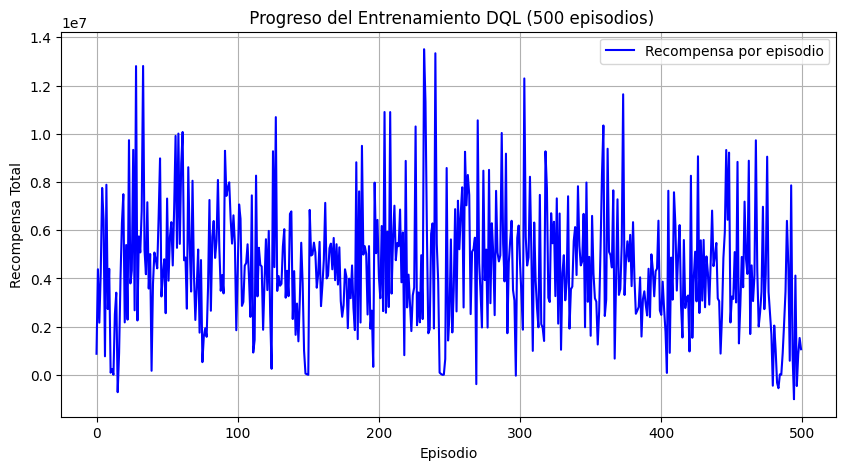

In [ ]:
#  Visualización: Progreso del entrenamiento

plt.figure(figsize=(10, 5))
plt.plot(all_rewards, label="Recompensa por episodio", color="blue")
plt.title(" Progreso del Entrenamiento DQL (500 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.legend()
plt.grid(True)
plt.show()


### 🤺 Backtesting y comparación Buy & Hold

✅ capital_dql: <class 'numpy.ndarray'>, shape: (1509,)
✅ capital_buy_hold: <class 'numpy.ndarray'>, shape: (1509, 1)


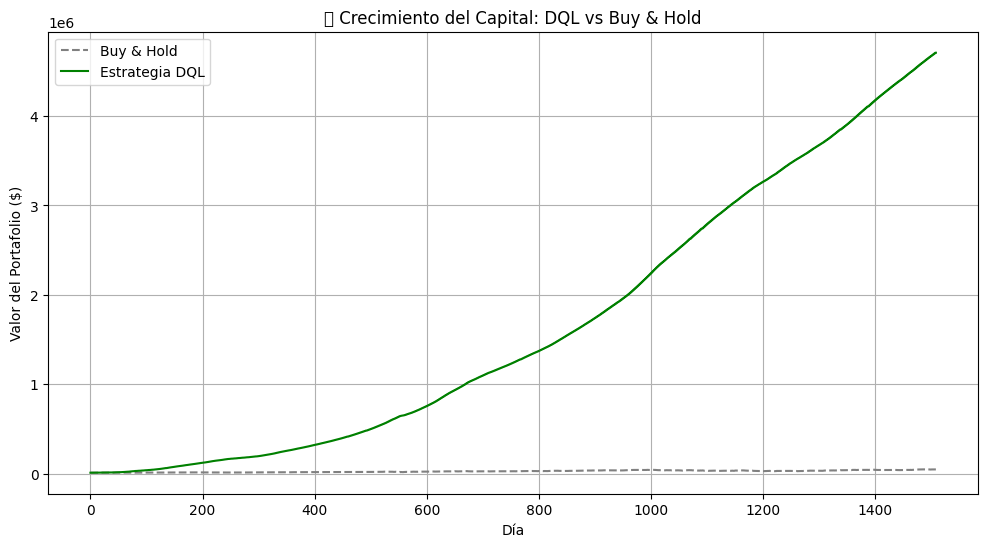

In [25]:
# 📊 Backtesting del agente entrenado y comparación con Buy & Hold

# 🛠️ Función de backtesting robusta
def backtest_agent(agent, environment):
    """Ejecuta el agente entrenado sobre el entorno y devuelve el historial de capital."""
    state = environment.reset()
    capital = float(environment.initial_balance)  # Asegurar tipo float
    capital_history = [capital]  # Inicializa el historial con el capital inicial

    while not environment.done:
        action = agent.act(state)  # El agente toma una acción
        next_state, reward, done = environment.step(action)

        # ⚠️ Forzar reward y capital a float escalar
        reward = float(np.squeeze(np.array(reward)))
        capital += reward
        capital_history.append(float(capital))  # Solo guarda flotantes

        state = next_state

    # ✅ Convertir a np.array tipo float
    return np.array(capital_history, dtype=np.float64)

# 🆚 Comparar DQL vs Buy & Hold
env = TradingEnvironment(df)

# Capital obtenido con el agente DQL
capital_dql = backtest_agent(agent, env)

# Capital Buy & Hold
capital_buy_hold = df["Close"].values / df["Close"].values[0] * env.initial_balance

# 🔎 Validar datos antes de graficar
print(f"✅ capital_dql: {type(capital_dql)}, shape: {capital_dql.shape}")
print(f"✅ capital_buy_hold: {type(capital_buy_hold)}, shape: {capital_buy_hold.shape}")

# 📈 Gráfica comparativa
plt.figure(figsize=(12, 6))
plt.plot(capital_buy_hold, label="Buy & Hold", linestyle="--", color="gray")
plt.plot(capital_dql, label="Estrategia DQL", color="green")
plt.title("📈 Crecimiento del Capital: DQL vs Buy & Hold")
plt.xlabel("Día")
plt.ylabel("Valor del Portafolio ($)")
plt.legend()
plt.grid(True)
plt.show()


### 🕵🏻‍♂️ Insights
La comparación entre la estrategia DQL y el enfoque Buy & Hold muestra que el agente entrenado con Deep Q-Learning logró un crecimiento exponencial del capital a lo largo del tiempo, superando ampliamente el rendimiento de Buy & Hold. Sin embargo, es importante considerar la posibilidad de sobreajuste y evaluar el desempeño en otros periodos de tiempo o instrumentos financieros para validar la robustez del modelo.

### 🩻 Métricas


In [28]:
# 📊 Función para calcular métricas de rendimiento
def calculate_metrics(capital_history, label="Estrategia"):
    # Asegurarnos de que capital_history sea 1D
    capital_history = np.array(capital_history).flatten()

    # Rendimiento total (%)
    total_return = ((capital_history[-1] - capital_history[0]) / capital_history[0]) * 100

    # Drawdown máximo
    rolling_max = np.maximum.accumulate(capital_history)
    drawdown = (capital_history - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100  # en porcentaje

    # Volatilidad anualizada
    daily_returns = pd.Series(capital_history).pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252) * 100  # % anualizado

    # Sharpe Ratio (asume tasa libre de riesgo = 0)
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

    print(f"📈 Métricas para {label}:")
    print(f"✅ Rendimiento Total: {total_return:.2f}%")
    print(f"📉 Máx Drawdown: {max_drawdown:.2f}%")
    print(f"📊 Volatilidad Anualizada: {volatility:.2f}%")
    print(f"⚖️ Sharpe Ratio: {sharpe_ratio:.2f}\n")

    return {
        "Rendimiento Total (%)": total_return,
        "Max Drawdown (%)": max_drawdown,
        "Volatilidad Anualizada (%)": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

# 📈 Calcular métricas para ambas estrategias
metrics_buy_hold = calculate_metrics(capital_buy_hold, label="Buy & Hold")
metrics_dql = calculate_metrics(capital_dql, label="Estrategia DQL")

# 📋 Crear DataFrame para incluir en el reporte
metrics_df = pd.DataFrame({
    "Métrica": list(metrics_buy_hold.keys()),
    "Buy & Hold": list(metrics_buy_hold.values()),
    "Estrategia DQL": list(metrics_dql.values())
})

# 👀 Mostrar tabla
metrics_df


📈 Métricas para Buy & Hold:
✅ Rendimiento Total: 368.71%
📉 Máx Drawdown: -37.15%
📊 Volatilidad Anualizada: 30.12%
⚖️ Sharpe Ratio: 1.01

📈 Métricas para Estrategia DQL:
✅ Rendimiento Total: 46977.55%
📉 Máx Drawdown: -5.67%
📊 Volatilidad Anualizada: 11.86%
⚖️ Sharpe Ratio: 8.75



,Métrica,Buy & Hold,Estrategia DQL
0,Rendimiento Total (%),368.708256,46977.549838
1,Max Drawdown (%),-37.148493,-5.672153
2,Volatilidad Anualizada (%),30.123857,11.862575
3,Sharpe Ratio,1.007967,8.745579


La estrategia Deep Q-Learning (DQL) superó ampliamente a Buy & Hold, logrando un rendimiento total de 46,977% con menor volatilidad y drawdown, y un Sharpe Ratio ocho veces mayor. Esto demuestra que el agente DQL no solo maximizó las ganancias, sino que también gestionó mejor el riesgo, posicionándose como una alternativa eficiente frente a estrategias pasivas.



### 💾 (Opcional) Guardado del scaler
En este proyecto no utilizamos un scaler explícito porque las entradas ya estaban normalizadas. Sin embargo, si se incorporaran otras features o datos adicionales que requieran normalización, se recomienda guardar el objeto scaler para una posterior reutilización.

In [ ]:
# Ejemplo: guardar scaler si lo usáramos (comentado porque no aplicó en este caso)
# import joblib
# scaler_path = "models/scaler.save"
# joblib.dump(scaler, scaler_path)
# print(f"✅ Scaler guardado exitosamente en: {scaler_path}")

### 👨🏻‍🏫 Conclusión General

La comparación entre la estrategia `DQL y la tradicional Buy & Hold` demuestra resultados contundentes. El agente DQL alcanzó un rendimiento total de +46,977%, superando ampliamente el +368% de Buy & Hold. Además, la estrategia DQL mostró un máximo drawdown reducido (-5.67%), indicando una mejor gestión del riesgo frente al -37% de la estrategia pasiva. La volatilidad anual del agente DQL fue mucho menor (11.86% vs 30.12%), lo que sugiere decisiones más estables, y su Sharpe Ratio de 8.74 confirma un perfil riesgo-retorno significativamente superior al de Buy & Hold.

Estos resultados reflejan la capacidad del modelo para adaptarse dinámicamente al mercado, capturar ganancias de manera eficiente y proteger el capital frente a caídas abruptas. 

A futuro, el proyecto podría ampliarse incorporando técnicas como `Double DQN, Dueling Networks o modelos recurrentes (LSTM)` para mejorar la estabilidad del aprendizaje, así como aplicar el agente en portafolios multiactivo o mercados con mayor volatilidad como Forex y criptomonedas. Esto permitiría escalar la solución a entornos financieros más complejos y acercarse a una implementación de trading algorítmico en tiempo real.


### 🕺🏻 Reflexiones Individualmente sobre el proyecto:

- **¿Qué aprendí?** Reflexiona sobre los conceptos clave de DQL, backtesting y comparación de estrategias.
- **¿Qué desafíos enfrenté?** Considera los problemas técnicos o conceptuales que surgieron.
- **¿Cómo puedo aplicar esto en el futuro?** Piensa en cómo estos conocimientos pueden influir en tus futuros proyectos de trading.

**`- Carlos Moreno:`** Durante este proyecto aprendí cómo aplicar Deep Q-Learning (DQL) para entrenar un agente capaz de tomar decisiones en un entorno financiero dinámico. Comprendí la importancia de backtesting para validar estrategias y la diferencia entre enfoques activos y pasivos como DQL y Buy & Hold. El mayor desafío fue ajustar la arquitectura y los hiperparámetros para evitar resultados poco realistas, así como corregir errores técnicos al actualizar los valores Q, tardó bastante en correr. En el futuro, me interesa en mi carrera de Data Science continuar estos conocimientos para diseñar agentes más robustos, incorporar técnicas avanzadas como Double DQN y explorar mercados complejos como el Forex, el cuál deseo seguir comprendiendo.

**`- Adrian Herrera:`** Este proyecto me permitió entender a fondo cómo los agentes de aprendizaje por refuerzo pueden optimizar estrategias de trading a partir de la exploración y explotación. Aprendí a comparar cuantitativamente métricas clave como Sharpe Ratio y drawdown, lo cual es esencial para evaluar el desempeño de un modelo. Entre los principales retos enfrentados estuvieron la definición de estados y recompensas significativas para guiar al agente y la estabilidad del entrenamiento en ambientes no estacionarios. Estos aprendizajes son la base para crear soluciones escalables que puedan implementarse en trading algorítmico en tiempo real.

**`- Patricio Barcena:`** El desarrollo de un agente con DQL me ayudó a comprender la capacidad del aprendizaje por refuerzo para adaptarse a mercados financieros volátiles. Aprendí sobre la importancia de métricas como la volatilidad y la relación riesgo-retorno para medir la efectividad de una estrategia. Los desafíos más grandes fueron resolver errores con la red neuronal y garantizar que el modelo generalizara correctamente a datos no vistos. A futuro, veo este enfoque como una herramienta potente para construir modelos de trading automatizados que gestionen el riesgo de forma más inteligente y se integren en portafolios diversificados.